# Reinforcement Learning

## 0. Introduction

This notebook is part of my work on the topic **Reinforcement Learning in Gaming** for the module *Reinforcement Learning* in course *WWI20DSB* supervised by Janina Patzer at the Baden-Wuerttemberg Cooperative State University Mannheim.

- Max Bernauer

This notebook focuses on implementing an environment and an agent to play Super Mario Bros. To implement the environment gym, nes_py and gym_super_mario_bros were used. The agent was created using a Double Deep Q Network based on PyTorch.

The creation of this notebook is based on several other notebooks and articles:

- [Liams DQN Notebook](https://https://colab.research.google.com/drive/1NsbSPn6jOcaJB_mp9TmkgQX7UrRIrTi0#scrollTo=GDZ6Kub4Gopl)

- Andrew Grebenisan: Article: [Play Super Mario Bros with a Double Deep Q-Network](https://blog.paperspace.com/building-double-deep-q-network-super-mario-bros/) Repository: [GitHub](https://github.com/DrJessop/MarioReinforcementLearning/tree/master)

- Akilesh: Article: [Reinforcement Learning in Super Mario Bros](https://dev.to/akilesh/reinforcement-learning-in-super-mario-bros-56i9)

- Q-Learning Analysis - Reinforcement Learning [Tutorial](https://pythonprogramming.net/q-learning-analysis-reinforcement-learning-python-tutorial/)

Which part of the code is inspired by which notebook is marked in the respective section of the notebook.

## 1. Setup / Prequesites

### 1.1 Downloads

In [1]:
# Packages needed to create the Super Mario Bros environment
! pip install nes_py
! pip install gym-super-mario-bros

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 593.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00
  Created wheel for nes_py: filename=nes_py-8.2.1-cp310-cp310-linux_x86_64.whl size=535685 sha256=7770a1ce532500047d6b729d80fb60647c4629c10d6aa773476f663dd7250dd2
  Stored in directory: /root/.cache/pip/wheels/34/a7/d5/9aa14b15df740a53d41f702e4c795731b6c4da7925deb8476c
Successfully built nes_py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 3.8 MB/s eta 0:00:00


In [2]:
# Packages needed to record and display a video of the agent in the environment
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 9 not upgraded.
Need to get 7,812 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.

### 1.2 Imports

In [3]:
# Packages to create the environment
import gym
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY
import collections
import cv2
import numpy as np

# Packages to create the Double DQN and the agent and visualize the reward curves
import torch
import torch.nn as nn
from tqdm import tqdm
import random
import pickle
import math
import matplotlib.pyplot as plt

# Packages needed to record and display a video of the agent in the environment
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo

In [4]:
# from pyvirtualdisplay import Display

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1.3 Configuration

In [5]:
# checks if GPU is available to accelerate training
if torch.cuda.is_available():
  print('GPU available')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

GPU available


## 2. Environment

### 2.1 Environment Wrapper

The original version of the wrapper is from https://colab.research.google.com/drive/1NsbSPn6jOcaJB_mp9TmkgQX7UrRIrTi0.

The version implemented and slightly adapted here is from https://github.com/DrJessop/MarioReinforcementLearning/tree/master.

In [6]:
# class to create the training environment
class MaxAndSkipEnv(gym.Wrapper):

    # Contructor
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    # Perform the steps during training
    def step(self, action):
        total_reward = 0.0
        done = None

        # loop to perform steps until goal is reached or the time is up
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    # Clear past frame buffer and init to first state
    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs

# Performs downsampling of the images to 84x84 and greyscaling to increase performance when displaying the environment
class ProcessFrame84(gym.ObservationWrapper):

    # Constructor
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    # Function to return the processesd image of the envrionment
    def observation(self, obs):
        return ProcessFrame84.process(obs)

    # Function to process the environment
    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

# Transforming the image of the environment that it fits the agent
class ImageToPyTorch(gym.ObservationWrapper):
    # Constructor
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

# Normalization of the pixels to values between 0 and 1
class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

# Updating the environment
class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

# Function to combine the functions above into one to create an environment by calling one function
def make_env(env):
    env = MaxAndSkipEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, RIGHT_ONLY)

### 2.2 Environment Overview

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is 

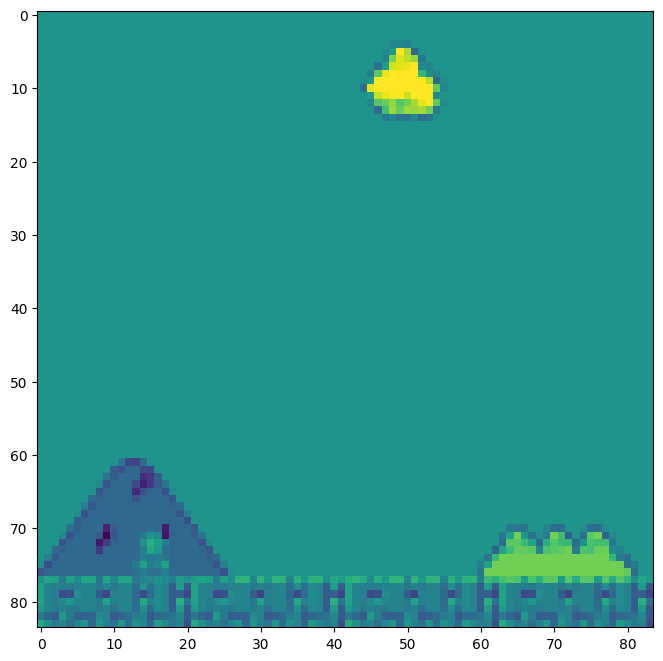

In [7]:
# Creating an environment as test
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0') # Environment creation
env = make_env(env)  # Environment wrapping to grayscale
env.reset() # Initializing the environment

# Performing one test step
new_action = env.action_space.sample() # Pulls a random action from the sample space
state, reward, done, info = env.step(new_action) # Uses the random action to perform a step

# Plotting the environment after the random action to get familiar with it
plt.figure(figsize=(10,8))
for idx in state:
    plt.imshow(idx)
plt.show()

## 3. Double Deep Q Network

### 3.1 Double DQN Creation

The original version of the DQN is from https://colab.research.google.com/drive/1NsbSPn6jOcaJB_mp9TmkgQX7UrRIrTi0.

The version implemented and slightly adapted here is from https://github.com/DrJessop/MarioReinforcementLearning/tree/master.

In [8]:
# Creation of the DQN
class DQNSolver(nn.Module):

    # Constructor, creation of the layers of the DQN
    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        # Creation of the DQN with one input layer and two Convolutional layers
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        # Creation of the classification layer
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

### 3.2 Agent Creation

In [9]:
class DQNAgent:

    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 dropout, exploration_max, exploration_min, exploration_decay, double_dq, pretrained):

        # Calling the functions to create the DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.double_dq = double_dq
        self.pretrained = pretrained

        # Checks if GPU is available to accelerate training
        print(torch.cuda.is_available())
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(self.device)

        # checks if a Double DQN should be created => will be done every time in this notebook as the performance was way better than the performance of the normal DQN
        # if self.double_dq:
        self.local_net = DQNSolver(state_space, action_space).to(self.device)
        self.target_net = DQNSolver(state_space, action_space).to(self.device)

        # Checking if a pretrained model should be loaded => was done a few times when the notebook crashed due to too little RAM
        if self.pretrained:
            self.local_net.load_state_dict(torch.load("dq1.pt", map_location=torch.device(self.device)))
            self.target_net.load_state_dict(torch.load("dq2.pt", map_location=torch.device(self.device)))

        # Setting Adam as model optimizer
        self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)

        # Setting the steps after which the target network is updated to 5000
        self.copy = 5000
        self.step = 0

        # else:
        #     self.dqn = DQNSolver(state_space, action_space).to(self.device)

        #     if self.pretrained:
        #         self.dqn.load_state_dict(torch.load("dq.pt", map_location=torch.device(self.device)))
        #     self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        # Setting the maximum memory of the DQN
        self.max_memory_size = max_memory_size

        # Checking if the memory of a pretrained model should be loaded => was done a few times when the notebook crashed due to too little RAM
        if self.pretrained:
            self.STATE_MEM = torch.load("STATE_MEM.pt")
            self.ACTION_MEM = torch.load("ACTION_MEM.pt")
            self.REWARD_MEM = torch.load("REWARD_MEM.pt")
            self.STATE2_MEM = torch.load("STATE2_MEM.pt")
            self.DONE_MEM = torch.load("DONE_MEM.pt")
            with open("ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)

        # loading the memory of the currently trained DQN during training
        else:
            self.STATE_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.ACTION_MEM = torch.zeros(max_memory_size, 1)
            self.REWARD_MEM = torch.zeros(max_memory_size, 1)
            self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.DONE_MEM = torch.zeros(max_memory_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0

        # Setting the sample size of the memory
        self.memory_sample_size = batch_size

        # Setting the learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    # Function to load the previous experience during training
    def remember(self, state, action, reward, state2, done):
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)

    # Function to call random experiences of previous episodes during training
    def recall(self):
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)

        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]

        return STATE, ACTION, REWARD, STATE2, DONE

    # Function to perform the action
    def act(self, state):
        # Epsilon-greedy action
        if self.double_dq:
            self.step += 1

        if random.random() < self.exploration_rate:
            return torch.tensor([[random.randrange(self.action_space)]])

        if self.double_dq:
            # Local net is used for the policy
            return torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()

    # Function to copy the weights of the local network to the target net every 5000 steps (5000 was set above)
    def copy_model(self):
        self.target_net.load_state_dict(self.local_net.state_dict())

    #
    def experience_replay(self):

        if self.double_dq and self.step % self.copy == 0:
            self.copy_model()

        if self.memory_sample_size > self.num_in_queue:
            return

        STATE, ACTION, REWARD, STATE2, DONE = self.recall()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)

        self.optimizer.zero_grad()
        if self.double_dq:
            # Double Q-Learning target function is Q*(S, A) <- r + γ max_a Q_target(S', a)
            target = REWARD + torch.mul((self.gamma *
                                        self.target_net(STATE2).max(1).values.unsqueeze(1)),
                                        1 - DONE)

            current = self.local_net(STATE).gather(1, ACTION.long()) # Local net approximation of Q-value
        else:
            # Q-Learning target function is Q*(S, A) <- r + γ max_a Q(S', a)
            target = REWARD + torch.mul((self.gamma *
                                        self.dqn(STATE2).max(1).values.unsqueeze(1)),
                                        1 - DONE)

            current = self.dqn(STATE).gather(1, ACTION.long())

        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exploration_decay

        # Checks that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)

### 3.3 Agent in Environment Overview



The evaluate function is based on https://github.com/DrJessop/MarioReinforcementLearning/tree/master and was slightly adapted.

In [10]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
# Function to show the video of the agent in the environment
def show_video():

  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

In [11]:
# Function to predict and perform one episode in the evironment to get familiar with the behavior of the agent
def evaluate(training_mode, pretrained):

  total_rewards = []

  # Creation of the environment
  env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
  env = make_env(env)

  # Setting up the video to record the episode
  env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
  observation_space = env.observation_space.shape
  action_space = env.action_space.n

  # Creating the agent
  agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     dropout=0.,
                     exploration_max=1.0,
                     exploration_min=0.02,
                     exploration_decay=0.99,
                     double_dq=True,
                     pretrained=pretrained)

  # Initializinh the environment
  state = env.reset()
  state = torch.Tensor([state])
  total_reward = 0

  while True:

    # Getting the action to perform
    action = agent.act(state)

    # Performing the predicted action
    state_next, reward, done, info = env.step(int(action[0]))
    total_reward += reward
    state_next = torch.Tensor([state_next])
    reward = torch.tensor([reward]).unsqueeze(0)

    if done:
      break

    total_rewards.append(total_reward)

  # Printing the achieved reward
  print("Total reward is {}".format(total_rewards[-1]))

  try:
    env.close()
  except:
    pass

  return total_rewards

# Calling the function to create an agent to perform on episode
total_rewards = evaluate(training_mode=True, pretrained=False)
print(total_rewards)

True
cuda


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:67: DeprecationWarning: WARN: `env.metadata["render.modes"] is marked as deprecated and will be replaced with `env.metadata["render_modes"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment SuperMarioBros-1-1-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:149: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argumen

Total reward is 1016.0
[0.0, 2.0, 4.0, 7.0, 9.0, 14.0, 20.0, 28.0, 38.0, 47.0, 58.0, 70.0, 82.0, 90.0, 97.0, 106.0, 117.0, 129.0, 141.0, 152.0, 164.0, 176.0, 184.0, 191.0, 196.0, 203.0, 210.0, 217.0, 224.0, 231.0, 239.0, 247.0, 257.0, 260.0, 259.0, 259.0, 261.0, 265.0, 270.0, 274.0, 279.0, 284.0, 291.0, 298.0, 304.0, 311.0, 318.0, 325.0, 331.0, 337.0, 344.0, 351.0, 358.0, 365.0, 371.0, 378.0, 384.0, 383.0, 384.0, 385.0, 388.0, 393.0, 398.0, 405.0, 411.0, 418.0, 425.0, 432.0, 439.0, 445.0, 453.0, 460.0, 469.0, 480.0, 491.0, 503.0, 515.0, 527.0, 539.0, 550.0, 562.0, 574.0, 586.0, 598.0, 609.0, 621.0, 633.0, 645.0, 657.0, 664.0, 664.0, 664.0, 664.0, 664.0, 663.0, 663.0, 663.0, 663.0, 663.0, 662.0, 662.0, 662.0, 662.0, 662.0, 661.0, 661.0, 661.0, 661.0, 661.0, 660.0, 660.0, 660.0, 660.0, 660.0, 659.0, 659.0, 659.0, 659.0, 659.0, 658.0, 658.0, 658.0, 658.0, 658.0, 657.0, 657.0, 657.0, 657.0, 657.0, 656.0, 656.0, 656.0, 656.0, 656.0, 655.0, 655.0, 655.0, 655.0, 655.0, 654.0, 654.0, 654.0, 65

In [12]:
# Displaying the video to get familiar with the behvaior of the agent
show_video()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 4. Training

The original version of the training loop is from https://colab.research.google.com/drive/1NsbSPn6jOcaJB_mp9TmkgQX7UrRIrTi0.

The version of the training loop which was implemented and slightly adapted is from https://github.com/DrJessop/MarioReinforcementLearning/tree/master.

In [13]:
# Function to train the agent
def train(training_mode, pretrained, num_episodes):

    # Creating the environment
    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
    env = make_env(env)  # Wraps the environment so that frames are grayscale

    # Checking if a pretrained model should be loaded
    # if pretrained:
    #   env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)

    # Setting up the observation and the action space
    observation_space = env.observation_space.shape
    action_space = env.action_space.n

    # Creating the agent
    agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     dropout=0.,
                     exploration_max=1.0,
                     exploration_min=0.02,
                     exploration_decay=0.99,
                     double_dq=True,
                     pretrained=pretrained)

    # num_episodes = 1000
    # Initializing the environment
    env.reset()
    total_rewards, episodes = [], []

    # Training loop => is executed as often as defined when calling the function
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor([state])
        total_reward, steps = 0, 0

        # Performing the epsiodes
        while True:
            # Getting the action to perform
            action = agent.act(state)
            steps += 1

            # Performing the predicted action
            state_next, reward, done, info = env.step(int(action[0]))
            total_reward += reward
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)

            # Transformation of the done variable
            done = torch.tensor([int(done)]).unsqueeze(0)

            # Taking experience of previous episodes into account during training
            if training_mode:
                agent.remember(state, action, reward, state_next, done)
                agent.experience_replay()

            state = state_next

            # Checking if the agent reached the goal or if the time is up
            if done:
                break

        # Saving the rewards and episodes
        total_rewards.append(total_reward)
        episodes.append(ep_num)

        # Printing the achieved reward for each episode
        print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
        # num_episodes += 1

    # Saving the model weights/experience during training
    if training_mode:
        with open("ending_position.pkl", "wb") as f:
            pickle.dump(agent.ending_position, f)
        with open("num_in_queue.pkl", "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        with open("total_rewards.pkl", "wb") as f:
            pickle.dump(total_rewards, f)
        if agent.double_dq:
            torch.save(agent.local_net.state_dict(), "dq1.pt")
            torch.save(agent.target_net.state_dict(), "dq2.pt")
        else:
            torch.save(agent.dqn.state_dict(), "dq.pt")

        torch.save(agent.STATE_MEM,  "STATE_MEM.pt")
        torch.save(agent.ACTION_MEM, "ACTION_MEM.pt")
        torch.save(agent.REWARD_MEM, "REWARD_MEM.pt")
        torch.save(agent.STATE2_MEM, "STATE2_MEM.pt")
        torch.save(agent.DONE_MEM,   "DONE_MEM.pt")

    env.close()
    return total_rewards, episodes

In [14]:
# Training the agent for 1000 episodes
total_rewards, episodes = train(training_mode=True, pretrained=False, num_episodes=1000)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


True
cuda


  0%|          | 1/1000 [00:21<5:54:01, 21.26s/it]

Total reward after episode 1 is 1007.0


  0%|          | 2/1000 [00:22<2:36:54,  9.43s/it]

Total reward after episode 2 is 233.0


  0%|          | 3/1000 [00:23<1:35:32,  5.75s/it]

Total reward after episode 3 is 231.0


  0%|          | 4/1000 [00:25<1:10:55,  4.27s/it]

Total reward after episode 4 is 231.0


  0%|          | 5/1000 [00:26<51:51,  3.13s/it]  

Total reward after episode 5 is 231.0


  1%|          | 6/1000 [00:27<40:25,  2.44s/it]

Total reward after episode 6 is 231.0


  1%|          | 7/1000 [00:29<35:21,  2.14s/it]

Total reward after episode 7 is 231.0


  1%|          | 8/1000 [00:31<32:51,  1.99s/it]

Total reward after episode 8 is 225.0


  1%|          | 9/1000 [00:32<28:22,  1.72s/it]

Total reward after episode 9 is 231.0


  1%|          | 10/1000 [00:33<25:23,  1.54s/it]

Total reward after episode 10 is 231.0


  1%|          | 11/1000 [00:47<1:30:08,  5.47s/it]

Total reward after episode 11 is 519.0


  1%|          | 12/1000 [00:48<1:06:59,  4.07s/it]

Total reward after episode 12 is 252.0


  1%|▏         | 13/1000 [00:49<50:31,  3.07s/it]  

Total reward after episode 13 is 251.0


  1%|▏         | 14/1000 [00:50<39:00,  2.37s/it]

Total reward after episode 14 is 249.0


  2%|▏         | 15/1000 [00:50<30:52,  1.88s/it]

Total reward after episode 15 is 248.0


  2%|▏         | 16/1000 [00:51<25:22,  1.55s/it]

Total reward after episode 16 is 249.0


  2%|▏         | 17/1000 [00:52<21:24,  1.31s/it]

Total reward after episode 17 is 252.0


  2%|▏         | 18/1000 [00:53<18:39,  1.14s/it]

Total reward after episode 18 is 252.0


  2%|▏         | 19/1000 [00:54<18:28,  1.13s/it]

Total reward after episode 19 is 248.0


  2%|▏         | 20/1000 [00:55<18:45,  1.15s/it]

Total reward after episode 20 is 252.0


  2%|▏         | 21/1000 [00:56<17:25,  1.07s/it]

Total reward after episode 21 is 252.0


  2%|▏         | 22/1000 [00:57<15:52,  1.03it/s]

Total reward after episode 22 is 251.0


  2%|▏         | 23/1000 [00:57<14:50,  1.10it/s]

Total reward after episode 23 is 251.0


  2%|▏         | 24/1000 [00:58<14:00,  1.16it/s]

Total reward after episode 24 is 248.0


  2%|▎         | 25/1000 [00:59<13:33,  1.20it/s]

Total reward after episode 25 is 249.0


  3%|▎         | 26/1000 [01:00<13:16,  1.22it/s]

Total reward after episode 26 is 250.0


  3%|▎         | 27/1000 [01:01<13:05,  1.24it/s]

Total reward after episode 27 is 249.0


  3%|▎         | 28/1000 [01:01<12:55,  1.25it/s]

Total reward after episode 28 is 251.0


  3%|▎         | 29/1000 [01:02<12:51,  1.26it/s]

Total reward after episode 29 is 251.0


  3%|▎         | 30/1000 [01:03<12:35,  1.28it/s]

Total reward after episode 30 is 252.0


  3%|▎         | 31/1000 [01:04<12:22,  1.31it/s]

Total reward after episode 31 is 252.0


  3%|▎         | 32/1000 [01:04<12:11,  1.32it/s]

Total reward after episode 32 is 250.0


  3%|▎         | 33/1000 [01:05<12:18,  1.31it/s]

Total reward after episode 33 is 251.0


  3%|▎         | 34/1000 [01:06<13:20,  1.21it/s]

Total reward after episode 34 is 251.0


  4%|▎         | 35/1000 [01:07<15:05,  1.07it/s]

Total reward after episode 35 is 247.0


  4%|▎         | 36/1000 [01:08<15:34,  1.03it/s]

Total reward after episode 36 is 252.0


  4%|▎         | 37/1000 [01:09<14:38,  1.10it/s]

Total reward after episode 37 is 251.0


  4%|▍         | 38/1000 [01:10<13:53,  1.15it/s]

Total reward after episode 38 is 252.0


  4%|▍         | 39/1000 [01:11<13:26,  1.19it/s]

Total reward after episode 39 is 251.0


  4%|▍         | 40/1000 [01:11<12:59,  1.23it/s]

Total reward after episode 40 is 252.0


  4%|▍         | 41/1000 [01:12<12:38,  1.26it/s]

Total reward after episode 41 is 252.0


  4%|▍         | 42/1000 [01:13<12:38,  1.26it/s]

Total reward after episode 42 is 252.0


  4%|▍         | 43/1000 [01:14<12:22,  1.29it/s]

Total reward after episode 43 is 250.0


  4%|▍         | 44/1000 [01:14<12:12,  1.30it/s]

Total reward after episode 44 is 248.0


  4%|▍         | 45/1000 [01:15<12:14,  1.30it/s]

Total reward after episode 45 is 251.0


  5%|▍         | 46/1000 [01:16<12:02,  1.32it/s]

Total reward after episode 46 is 248.0


  5%|▍         | 47/1000 [01:17<12:05,  1.31it/s]

Total reward after episode 47 is 250.0


  5%|▍         | 48/1000 [01:18<13:52,  1.14it/s]

Total reward after episode 48 is 252.0


  5%|▍         | 49/1000 [01:19<14:26,  1.10it/s]

Total reward after episode 49 is 248.0


  5%|▌         | 50/1000 [01:23<31:28,  1.99s/it]

Total reward after episode 50 is 625.0


  5%|▌         | 51/1000 [01:25<32:13,  2.04s/it]

Total reward after episode 51 is 639.0


  5%|▌         | 52/1000 [01:28<32:37,  2.06s/it]

Total reward after episode 52 is 636.0


  5%|▌         | 53/1000 [01:30<32:19,  2.05s/it]

Total reward after episode 53 is 631.0


  5%|▌         | 54/1000 [01:33<40:30,  2.57s/it]

Total reward after episode 54 is 621.0


  6%|▌         | 55/1000 [01:39<52:49,  3.35s/it]

Total reward after episode 55 is 1035.0


  6%|▌         | 56/1000 [01:40<46:03,  2.93s/it]

Total reward after episode 56 is 609.0


  6%|▌         | 57/1000 [01:42<41:47,  2.66s/it]

Total reward after episode 57 is 633.0


  6%|▌         | 58/1000 [01:51<1:08:09,  4.34s/it]

Total reward after episode 58 is 1322.0


  6%|▌         | 59/1000 [01:56<1:14:33,  4.75s/it]

Total reward after episode 59 is 1033.0


  6%|▌         | 60/1000 [02:00<1:06:35,  4.25s/it]

Total reward after episode 60 is 649.0


  6%|▌         | 61/1000 [02:02<55:50,  3.57s/it]  

Total reward after episode 61 is 621.0


  6%|▌         | 62/1000 [02:04<49:49,  3.19s/it]

Total reward after episode 62 is 617.0


  6%|▋         | 63/1000 [02:08<56:02,  3.59s/it]

Total reward after episode 63 is 1037.0


  6%|▋         | 64/1000 [02:11<53:01,  3.40s/it]

Total reward after episode 64 is 652.0


  6%|▋         | 65/1000 [02:13<45:54,  2.95s/it]

Total reward after episode 65 is 627.0


  7%|▋         | 66/1000 [02:14<35:43,  2.29s/it]

Total reward after episode 66 is 251.0


  7%|▋         | 67/1000 [02:15<31:32,  2.03s/it]

Total reward after episode 67 is 250.0


  7%|▋         | 68/1000 [02:20<42:55,  2.76s/it]

Total reward after episode 68 is 626.0


  7%|▋         | 69/1000 [02:23<46:54,  3.02s/it]

Total reward after episode 69 is 607.0


  7%|▋         | 70/1000 [02:26<42:43,  2.76s/it]

Total reward after episode 70 is 633.0


  7%|▋         | 71/1000 [02:38<1:29:06,  5.75s/it]

Total reward after episode 71 is 1413.0


  7%|▋         | 72/1000 [02:40<1:10:32,  4.56s/it]

Total reward after episode 72 is 623.0


  7%|▋         | 73/1000 [02:47<1:19:53,  5.17s/it]

Total reward after episode 73 is 796.0


  7%|▋         | 74/1000 [02:50<1:10:45,  4.59s/it]

Total reward after episode 74 is 635.0


  8%|▊         | 75/1000 [02:51<53:19,  3.46s/it]  

Total reward after episode 75 is 248.0


  8%|▊         | 76/1000 [02:54<53:43,  3.49s/it]

Total reward after episode 76 is 616.0


  8%|▊         | 77/1000 [02:55<41:14,  2.68s/it]

Total reward after episode 77 is 249.0


  8%|▊         | 78/1000 [02:59<47:08,  3.07s/it]

Total reward after episode 78 is 626.0


  8%|▊         | 79/1000 [03:03<50:16,  3.28s/it]

Total reward after episode 79 is 630.0


  8%|▊         | 80/1000 [03:05<46:29,  3.03s/it]

Total reward after episode 80 is 632.0


  8%|▊         | 81/1000 [03:06<36:18,  2.37s/it]

Total reward after episode 81 is 251.0


  8%|▊         | 82/1000 [03:15<1:05:31,  4.28s/it]

Total reward after episode 82 is 1305.0


  8%|▊         | 83/1000 [03:17<56:27,  3.69s/it]  

Total reward after episode 83 is 629.0


  8%|▊         | 84/1000 [03:19<48:36,  3.18s/it]

Total reward after episode 84 is 625.0


  8%|▊         | 85/1000 [03:21<42:50,  2.81s/it]

Total reward after episode 85 is 627.0


  9%|▊         | 86/1000 [03:30<1:10:42,  4.64s/it]

Total reward after episode 86 is 578.0


  9%|▊         | 87/1000 [03:32<57:55,  3.81s/it]  

Total reward after episode 87 is 627.0


  9%|▉         | 88/1000 [03:34<50:09,  3.30s/it]

Total reward after episode 88 is 631.0


  9%|▉         | 89/1000 [03:41<1:07:02,  4.42s/it]

Total reward after episode 89 is 628.0


  9%|▉         | 90/1000 [03:43<55:50,  3.68s/it]  

Total reward after episode 90 is 627.0


  9%|▉         | 91/1000 [03:53<1:22:35,  5.45s/it]

Total reward after episode 91 is 1566.0


  9%|▉         | 92/1000 [03:53<1:01:20,  4.05s/it]

Total reward after episode 92 is 252.0


  9%|▉         | 93/1000 [03:59<1:07:47,  4.48s/it]

Total reward after episode 93 is 769.0


  9%|▉         | 94/1000 [04:00<51:01,  3.38s/it]  

Total reward after episode 94 is 251.0


 10%|▉         | 95/1000 [04:02<46:17,  3.07s/it]

Total reward after episode 95 is 625.0


 10%|▉         | 96/1000 [04:14<1:28:00,  5.84s/it]

Total reward after episode 96 is 1280.0


 10%|▉         | 97/1000 [04:15<1:06:18,  4.41s/it]

Total reward after episode 97 is 251.0


 10%|▉         | 98/1000 [04:21<1:12:49,  4.84s/it]

Total reward after episode 98 is 625.0


 10%|▉         | 99/1000 [04:26<1:13:44,  4.91s/it]

Total reward after episode 99 is 1589.0


 10%|█         | 100/1000 [04:27<54:59,  3.67s/it] 

Total reward after episode 100 is 252.0


 10%|█         | 101/1000 [04:29<48:32,  3.24s/it]

Total reward after episode 101 is 234.0


 10%|█         | 102/1000 [04:32<44:12,  2.95s/it]

Total reward after episode 102 is 248.0


 10%|█         | 103/1000 [04:32<34:32,  2.31s/it]

Total reward after episode 103 is 250.0


 10%|█         | 104/1000 [04:44<1:14:10,  4.97s/it]

Total reward after episode 104 is 1399.0


 10%|█         | 105/1000 [04:46<1:03:32,  4.26s/it]

Total reward after episode 105 is 618.0


 11%|█         | 106/1000 [04:47<48:09,  3.23s/it]  

Total reward after episode 106 is 251.0


 11%|█         | 107/1000 [04:53<58:53,  3.96s/it]

Total reward after episode 107 is 1432.0


 11%|█         | 108/1000 [04:56<54:02,  3.63s/it]

Total reward after episode 108 is 634.0


 11%|█         | 109/1000 [04:58<46:54,  3.16s/it]

Total reward after episode 109 is 632.0


 11%|█         | 110/1000 [05:01<46:52,  3.16s/it]

Total reward after episode 110 is 625.0


 11%|█         | 111/1000 [05:04<49:01,  3.31s/it]

Total reward after episode 111 is 618.0


 11%|█         | 112/1000 [05:05<37:50,  2.56s/it]

Total reward after episode 112 is 251.0


 11%|█▏        | 113/1000 [05:12<54:11,  3.67s/it]

Total reward after episode 113 is 1428.0


 11%|█▏        | 114/1000 [05:16<56:48,  3.85s/it]

Total reward after episode 114 is 1435.0


 12%|█▏        | 115/1000 [05:18<48:16,  3.27s/it]

Total reward after episode 115 is 627.0


 12%|█▏        | 116/1000 [05:21<46:37,  3.16s/it]

Total reward after episode 116 is 632.0


 12%|█▏        | 117/1000 [05:22<40:38,  2.76s/it]

Total reward after episode 117 is 608.0


 12%|█▏        | 118/1000 [05:24<37:08,  2.53s/it]

Total reward after episode 118 is 622.0


 12%|█▏        | 119/1000 [05:27<36:29,  2.49s/it]

Total reward after episode 119 is 633.0


 12%|█▏        | 120/1000 [05:29<36:06,  2.46s/it]

Total reward after episode 120 is 623.0


 12%|█▏        | 121/1000 [05:34<46:12,  3.15s/it]

Total reward after episode 121 is 1163.0


 12%|█▏        | 122/1000 [05:35<35:46,  2.44s/it]

Total reward after episode 122 is 250.0


 12%|█▏        | 123/1000 [05:37<34:43,  2.38s/it]

Total reward after episode 123 is 634.0


 12%|█▏        | 124/1000 [05:44<54:04,  3.70s/it]

Total reward after episode 124 is 1416.0


 12%|█▎        | 125/1000 [05:47<53:40,  3.68s/it]

Total reward after episode 125 is 623.0


 13%|█▎        | 126/1000 [05:54<1:06:27,  4.56s/it]

Total reward after episode 126 is 1423.0


 13%|█▎        | 127/1000 [05:56<55:05,  3.79s/it]  

Total reward after episode 127 is 621.0


 13%|█▎        | 128/1000 [05:59<51:34,  3.55s/it]

Total reward after episode 128 is 636.0


 13%|█▎        | 129/1000 [06:04<56:39,  3.90s/it]

Total reward after episode 129 is 1587.0


 13%|█▎        | 130/1000 [06:06<47:29,  3.28s/it]

Total reward after episode 130 is 625.0


 13%|█▎        | 131/1000 [06:10<52:25,  3.62s/it]

Total reward after episode 131 is 724.0


 13%|█▎        | 132/1000 [06:15<59:15,  4.10s/it]

Total reward after episode 132 is 1342.0


 13%|█▎        | 133/1000 [06:18<52:03,  3.60s/it]

Total reward after episode 133 is 634.0


 13%|█▎        | 134/1000 [06:19<44:07,  3.06s/it]

Total reward after episode 134 is 624.0


 14%|█▎        | 135/1000 [06:24<49:58,  3.47s/it]

Total reward after episode 135 is 818.0


 14%|█▎        | 136/1000 [06:26<42:12,  2.93s/it]

Total reward after episode 136 is 607.0


 14%|█▎        | 137/1000 [06:29<46:35,  3.24s/it]

Total reward after episode 137 is 616.0


 14%|█▍        | 138/1000 [06:30<35:42,  2.49s/it]

Total reward after episode 138 is 247.0


 14%|█▍        | 139/1000 [06:31<28:37,  1.99s/it]

Total reward after episode 139 is 242.0


 14%|█▍        | 140/1000 [06:36<41:46,  2.92s/it]

Total reward after episode 140 is 1584.0


 14%|█▍        | 141/1000 [06:40<47:56,  3.35s/it]

Total reward after episode 141 is 595.0


 14%|█▍        | 142/1000 [06:44<49:50,  3.49s/it]

Total reward after episode 142 is 1431.0


 14%|█▍        | 143/1000 [06:54<1:15:55,  5.32s/it]

Total reward after episode 143 is 1556.0


 14%|█▍        | 144/1000 [06:56<1:00:54,  4.27s/it]

Total reward after episode 144 is 621.0


 14%|█▍        | 145/1000 [06:57<50:03,  3.51s/it]  

Total reward after episode 145 is 624.0


 15%|█▍        | 146/1000 [07:00<46:31,  3.27s/it]

Total reward after episode 146 is 612.0


 15%|█▍        | 147/1000 [07:06<59:26,  4.18s/it]

Total reward after episode 147 is 1430.0


 15%|█▍        | 148/1000 [07:09<51:05,  3.60s/it]

Total reward after episode 148 is 620.0


 15%|█▍        | 149/1000 [07:13<55:04,  3.88s/it]

Total reward after episode 149 is 614.0


 15%|█▌        | 150/1000 [07:15<47:20,  3.34s/it]

Total reward after episode 150 is 609.0


 15%|█▌        | 151/1000 [07:37<2:05:37,  8.88s/it]

Total reward after episode 151 is 2553.0


 15%|█▌        | 152/1000 [07:43<1:54:26,  8.10s/it]

Total reward after episode 152 is 1429.0


 15%|█▌        | 153/1000 [07:47<1:36:55,  6.87s/it]

Total reward after episode 153 is 1437.0


 15%|█▌        | 154/1000 [07:49<1:15:52,  5.38s/it]

Total reward after episode 154 is 623.0


 16%|█▌        | 155/1000 [07:57<1:26:06,  6.11s/it]

Total reward after episode 155 is 1324.0


 16%|█▌        | 156/1000 [08:01<1:16:55,  5.47s/it]

Total reward after episode 156 is 1438.0


 16%|█▌        | 157/1000 [08:04<1:04:58,  4.62s/it]

Total reward after episode 157 is 625.0


 16%|█▌        | 158/1000 [08:12<1:18:48,  5.62s/it]

Total reward after episode 158 is 1404.0


 16%|█▌        | 159/1000 [08:17<1:18:51,  5.63s/it]

Total reward after episode 159 is 1340.0


 16%|█▌        | 160/1000 [08:20<1:04:30,  4.61s/it]

Total reward after episode 160 is 632.0


 16%|█▌        | 161/1000 [08:22<53:41,  3.84s/it]  

Total reward after episode 161 is 630.0


 16%|█▌        | 162/1000 [08:26<54:12,  3.88s/it]

Total reward after episode 162 is 639.0


 16%|█▋        | 163/1000 [08:29<53:38,  3.85s/it]

Total reward after episode 163 is 603.0


 16%|█▋        | 164/1000 [08:47<1:49:36,  7.87s/it]

Total reward after episode 164 is 1350.0


 16%|█▋        | 165/1000 [08:48<1:23:29,  6.00s/it]

Total reward after episode 165 is 611.0


 17%|█▋        | 166/1000 [08:56<1:31:23,  6.57s/it]

Total reward after episode 166 is 1913.0


 17%|█▋        | 167/1000 [08:58<1:12:02,  5.19s/it]

Total reward after episode 167 is 609.0


 17%|█▋        | 168/1000 [09:01<1:02:49,  4.53s/it]

Total reward after episode 168 is 622.0


 17%|█▋        | 169/1000 [09:08<1:10:50,  5.12s/it]

Total reward after episode 169 is 1695.0


 17%|█▋        | 170/1000 [09:10<1:01:05,  4.42s/it]

Total reward after episode 170 is 611.0


 17%|█▋        | 171/1000 [09:16<1:08:01,  4.92s/it]

Total reward after episode 171 is 1425.0


 17%|█▋        | 172/1000 [09:22<1:12:25,  5.25s/it]

Total reward after episode 172 is 599.0


 17%|█▋        | 173/1000 [09:25<59:48,  4.34s/it]  

Total reward after episode 173 is 613.0


 17%|█▋        | 174/1000 [09:27<50:31,  3.67s/it]

Total reward after episode 174 is 623.0


 18%|█▊        | 175/1000 [09:30<49:46,  3.62s/it]

Total reward after episode 175 is 1150.0


 18%|█▊        | 176/1000 [09:33<46:34,  3.39s/it]

Total reward after episode 176 is 654.0


 18%|█▊        | 177/1000 [09:38<53:01,  3.87s/it]

Total reward after episode 177 is 808.0


 18%|█▊        | 178/1000 [09:40<43:44,  3.19s/it]

Total reward after episode 178 is 607.0


 18%|█▊        | 179/1000 [09:42<39:51,  2.91s/it]

Total reward after episode 179 is 613.0


 18%|█▊        | 180/1000 [09:50<58:54,  4.31s/it]

Total reward after episode 180 is 1407.0


 18%|█▊        | 181/1000 [09:50<44:49,  3.28s/it]

Total reward after episode 181 is 238.0


 18%|█▊        | 182/1000 [09:54<47:39,  3.50s/it]

Total reward after episode 182 is 1347.0


 18%|█▊        | 183/1000 [09:57<43:09,  3.17s/it]

Total reward after episode 183 is 624.0


 18%|█▊        | 184/1000 [09:59<40:25,  2.97s/it]

Total reward after episode 184 is 618.0


 18%|█▊        | 185/1000 [10:04<45:50,  3.37s/it]

Total reward after episode 185 is 812.0


 19%|█▊        | 186/1000 [10:11<1:02:11,  4.58s/it]

Total reward after episode 186 is 1696.0


 19%|█▊        | 187/1000 [10:13<52:34,  3.88s/it]  

Total reward after episode 187 is 630.0


 19%|█▉        | 188/1000 [10:15<44:37,  3.30s/it]

Total reward after episode 188 is 627.0


 19%|█▉        | 189/1000 [10:16<34:13,  2.53s/it]

Total reward after episode 189 is 248.0


 19%|█▉        | 190/1000 [10:20<41:42,  3.09s/it]

Total reward after episode 190 is 811.0


 19%|█▉        | 191/1000 [10:23<40:25,  3.00s/it]

Total reward after episode 191 is 620.0


 19%|█▉        | 192/1000 [10:27<42:59,  3.19s/it]

Total reward after episode 192 is 1349.0


 19%|█▉        | 193/1000 [10:29<38:07,  2.83s/it]

Total reward after episode 193 is 617.0


 19%|█▉        | 194/1000 [10:33<44:04,  3.28s/it]

Total reward after episode 194 is 1436.0


 20%|█▉        | 195/1000 [10:36<41:22,  3.08s/it]

Total reward after episode 195 is 624.0


 20%|█▉        | 196/1000 [10:40<47:17,  3.53s/it]

Total reward after episode 196 is 1041.0


 20%|█▉        | 197/1000 [10:41<36:50,  2.75s/it]

Total reward after episode 197 is 237.0


 20%|█▉        | 198/1000 [10:44<34:47,  2.60s/it]

Total reward after episode 198 is 636.0


 20%|█▉        | 199/1000 [10:49<44:05,  3.30s/it]

Total reward after episode 199 is 1338.0


 20%|██        | 200/1000 [10:50<37:04,  2.78s/it]

Total reward after episode 200 is 608.0


 20%|██        | 201/1000 [10:51<29:41,  2.23s/it]

Total reward after episode 201 is 232.0


 20%|██        | 202/1000 [11:01<1:02:27,  4.70s/it]

Total reward after episode 202 is 1294.0


 20%|██        | 203/1000 [11:06<1:03:20,  4.77s/it]

Total reward after episode 203 is 734.0


 20%|██        | 204/1000 [11:08<52:33,  3.96s/it]  

Total reward after episode 204 is 652.0


 20%|██        | 205/1000 [11:13<53:48,  4.06s/it]

Total reward after episode 205 is 641.0


 21%|██        | 206/1000 [11:21<1:10:53,  5.36s/it]

Total reward after episode 206 is 730.0


 21%|██        | 207/1000 [11:22<52:27,  3.97s/it]  

Total reward after episode 207 is 248.0


 21%|██        | 208/1000 [11:23<39:36,  3.00s/it]

Total reward after episode 208 is 252.0


 21%|██        | 209/1000 [11:25<37:08,  2.82s/it]

Total reward after episode 209 is 616.0


 21%|██        | 210/1000 [11:27<34:52,  2.65s/it]

Total reward after episode 210 is 638.0


 21%|██        | 211/1000 [11:37<1:03:11,  4.80s/it]

Total reward after episode 211 is 774.0


 21%|██        | 212/1000 [11:48<1:27:01,  6.63s/it]

Total reward after episode 212 is 1299.0


 21%|██▏       | 213/1000 [11:56<1:31:01,  6.94s/it]

Total reward after episode 213 is 792.0


 21%|██▏       | 214/1000 [11:56<1:06:31,  5.08s/it]

Total reward after episode 214 is 250.0


 22%|██▏       | 215/1000 [11:58<53:03,  4.06s/it]  

Total reward after episode 215 is 610.0


 22%|██▏       | 216/1000 [12:01<49:11,  3.76s/it]

Total reward after episode 216 is 614.0


 22%|██▏       | 217/1000 [12:02<38:46,  2.97s/it]

Total reward after episode 217 is 248.0


 22%|██▏       | 218/1000 [12:03<31:28,  2.42s/it]

Total reward after episode 218 is 252.0


 22%|██▏       | 219/1000 [12:04<25:13,  1.94s/it]

Total reward after episode 219 is 248.0


 22%|██▏       | 220/1000 [12:05<20:26,  1.57s/it]

Total reward after episode 220 is 248.0


 22%|██▏       | 221/1000 [12:10<32:20,  2.49s/it]

Total reward after episode 221 is 1146.0


 22%|██▏       | 222/1000 [12:15<45:33,  3.51s/it]

Total reward after episode 222 is 805.0


 22%|██▏       | 223/1000 [12:21<52:40,  4.07s/it]

Total reward after episode 223 is 806.0


 22%|██▏       | 224/1000 [12:23<43:51,  3.39s/it]

Total reward after episode 224 is 654.0


 22%|██▎       | 225/1000 [12:23<33:32,  2.60s/it]

Total reward after episode 225 is 250.0


 23%|██▎       | 226/1000 [12:29<44:58,  3.49s/it]

Total reward after episode 226 is 1329.0


 23%|██▎       | 227/1000 [12:31<40:02,  3.11s/it]

Total reward after episode 227 is 628.0


 23%|██▎       | 228/1000 [12:34<38:26,  2.99s/it]

Total reward after episode 228 is 622.0


 23%|██▎       | 229/1000 [12:38<43:18,  3.37s/it]

Total reward after episode 229 is 613.0


 23%|██▎       | 230/1000 [12:43<49:52,  3.89s/it]

Total reward after episode 230 is 1347.0


 23%|██▎       | 231/1000 [13:07<2:05:32,  9.80s/it]

Total reward after episode 231 is 940.0


 23%|██▎       | 232/1000 [13:14<1:56:27,  9.10s/it]

Total reward after episode 232 is 1040.0


 23%|██▎       | 233/1000 [13:15<1:24:38,  6.62s/it]

Total reward after episode 233 is 243.0


 23%|██▎       | 234/1000 [13:23<1:28:06,  6.90s/it]

Total reward after episode 234 is 1316.0


 24%|██▎       | 235/1000 [13:29<1:25:56,  6.74s/it]

Total reward after episode 235 is 1329.0


 24%|██▎       | 236/1000 [13:36<1:26:18,  6.78s/it]

Total reward after episode 236 is 1696.0


 24%|██▎       | 237/1000 [13:43<1:25:34,  6.73s/it]

Total reward after episode 237 is 1915.0


 24%|██▍       | 238/1000 [14:41<4:44:11, 22.38s/it]

Total reward after episode 238 is 267.0


 24%|██▍       | 239/1000 [14:43<3:24:45, 16.14s/it]

Total reward after episode 239 is 612.0


 24%|██▍       | 240/1000 [14:47<2:37:35, 12.44s/it]

Total reward after episode 240 is 611.0


 24%|██▍       | 241/1000 [14:49<1:56:58,  9.25s/it]

Total reward after episode 241 is 616.0


 24%|██▍       | 242/1000 [14:52<1:35:53,  7.59s/it]

Total reward after episode 242 is 1338.0


 24%|██▍       | 243/1000 [14:54<1:14:41,  5.92s/it]

Total reward after episode 243 is 624.0


 24%|██▍       | 244/1000 [15:00<1:13:58,  5.87s/it]

Total reward after episode 244 is 1342.0


 24%|██▍       | 245/1000 [15:02<59:41,  4.74s/it]  

Total reward after episode 245 is 639.0


 25%|██▍       | 246/1000 [15:09<1:05:39,  5.22s/it]

Total reward after episode 246 is 796.0


 25%|██▍       | 247/1000 [15:13<1:01:21,  4.89s/it]

Total reward after episode 247 is 1049.0


 25%|██▍       | 248/1000 [15:25<1:27:56,  7.02s/it]

Total reward after episode 248 is 991.0


 25%|██▍       | 249/1000 [15:31<1:23:35,  6.68s/it]

Total reward after episode 249 is 607.0


 25%|██▌       | 250/1000 [15:37<1:20:51,  6.47s/it]

Total reward after episode 250 is 805.0


 25%|██▌       | 251/1000 [15:38<1:00:19,  4.83s/it]

Total reward after episode 251 is 246.0


 25%|██▌       | 252/1000 [15:40<50:26,  4.05s/it]  

Total reward after episode 252 is 624.0


 25%|██▌       | 253/1000 [15:42<42:40,  3.43s/it]

Total reward after episode 253 is 637.0


 25%|██▌       | 254/1000 [15:45<43:30,  3.50s/it]

Total reward after episode 254 is 1351.0


 26%|██▌       | 255/1000 [15:51<51:00,  4.11s/it]

Total reward after episode 255 is 1582.0


 26%|██▌       | 256/1000 [15:53<43:33,  3.51s/it]

Total reward after episode 256 is 640.0


 26%|██▌       | 257/1000 [15:54<33:19,  2.69s/it]

Total reward after episode 257 is 242.0


 26%|██▌       | 258/1000 [15:55<25:58,  2.10s/it]

Total reward after episode 258 is 248.0


 26%|██▌       | 259/1000 [16:01<41:02,  3.32s/it]

Total reward after episode 259 is 1335.0


 26%|██▌       | 260/1000 [16:03<37:06,  3.01s/it]

Total reward after episode 260 is 611.0


 26%|██▌       | 261/1000 [16:09<46:21,  3.76s/it]

Total reward after episode 261 is 1029.0


 26%|██▌       | 262/1000 [16:13<49:45,  4.05s/it]

Total reward after episode 262 is 1040.0


 26%|██▋       | 263/1000 [16:17<47:40,  3.88s/it]

Total reward after episode 263 is 1051.0


 26%|██▋       | 264/1000 [16:21<47:25,  3.87s/it]

Total reward after episode 264 is 775.0


 26%|██▋       | 265/1000 [16:23<41:02,  3.35s/it]

Total reward after episode 265 is 634.0


 27%|██▋       | 266/1000 [16:25<35:48,  2.93s/it]

Total reward after episode 266 is 628.0


 27%|██▋       | 267/1000 [16:28<35:59,  2.95s/it]

Total reward after episode 267 is 737.0


 27%|██▋       | 268/1000 [16:32<39:47,  3.26s/it]

Total reward after episode 268 is 1044.0


 27%|██▋       | 269/1000 [16:35<41:54,  3.44s/it]

Total reward after episode 269 is 1348.0


 27%|██▋       | 270/1000 [16:39<41:12,  3.39s/it]

Total reward after episode 270 is 647.0


 27%|██▋       | 271/1000 [16:44<46:38,  3.84s/it]

Total reward after episode 271 is 1041.0


 27%|██▋       | 272/1000 [16:48<47:47,  3.94s/it]

Total reward after episode 272 is 1349.0


 27%|██▋       | 273/1000 [16:52<50:08,  4.14s/it]

Total reward after episode 273 is 1064.0


 27%|██▋       | 274/1000 [16:54<41:43,  3.45s/it]

Total reward after episode 274 is 608.0


 28%|██▊       | 275/1000 [17:12<1:32:46,  7.68s/it]

Total reward after episode 275 is 2294.0


 28%|██▊       | 276/1000 [17:14<1:12:41,  6.02s/it]

Total reward after episode 276 is 737.0


 28%|██▊       | 277/1000 [17:17<1:01:30,  5.10s/it]

Total reward after episode 277 is 637.0


 28%|██▊       | 278/1000 [17:22<1:00:43,  5.05s/it]

Total reward after episode 278 is 1039.0


 28%|██▊       | 279/1000 [17:24<49:11,  4.09s/it]  

Total reward after episode 279 is 634.0


 28%|██▊       | 280/1000 [17:29<52:11,  4.35s/it]

Total reward after episode 280 is 1344.0


 28%|██▊       | 281/1000 [17:33<51:32,  4.30s/it]

Total reward after episode 281 is 1349.0


 28%|██▊       | 282/1000 [17:35<42:47,  3.58s/it]

Total reward after episode 282 is 622.0


 28%|██▊       | 283/1000 [17:37<37:35,  3.15s/it]

Total reward after episode 283 is 632.0


 28%|██▊       | 284/1000 [17:42<45:36,  3.82s/it]

Total reward after episode 284 is 1041.0


 28%|██▊       | 285/1000 [17:43<35:17,  2.96s/it]

Total reward after episode 285 is 235.0


 29%|██▊       | 286/1000 [17:49<46:33,  3.91s/it]

Total reward after episode 286 is 1691.0


 29%|██▊       | 287/1000 [17:50<35:15,  2.97s/it]

Total reward after episode 287 is 248.0


 29%|██▉       | 288/1000 [17:51<27:36,  2.33s/it]

Total reward after episode 288 is 249.0


 29%|██▉       | 289/1000 [17:55<34:24,  2.90s/it]

Total reward after episode 289 is 819.0


 29%|██▉       | 290/1000 [17:57<31:36,  2.67s/it]

Total reward after episode 290 is 640.0


 29%|██▉       | 291/1000 [18:01<33:37,  2.84s/it]

Total reward after episode 291 is 1047.0


 29%|██▉       | 292/1000 [18:06<41:02,  3.48s/it]

Total reward after episode 292 is 1060.0


 29%|██▉       | 293/1000 [18:11<48:53,  4.15s/it]

Total reward after episode 293 is 1704.0


 29%|██▉       | 294/1000 [18:16<51:23,  4.37s/it]

Total reward after episode 294 is 1584.0


 30%|██▉       | 295/1000 [18:21<52:59,  4.51s/it]

Total reward after episode 295 is 1436.0


 30%|██▉       | 296/1000 [18:25<50:54,  4.34s/it]

Total reward after episode 296 is 603.0


 30%|██▉       | 297/1000 [18:27<42:57,  3.67s/it]

Total reward after episode 297 is 611.0


 30%|██▉       | 298/1000 [18:35<58:22,  4.99s/it]

Total reward after episode 298 is 791.0


 30%|██▉       | 299/1000 [18:36<43:30,  3.72s/it]

Total reward after episode 299 is 247.0


 30%|███       | 300/1000 [18:38<38:03,  3.26s/it]

Total reward after episode 300 is 636.0


 30%|███       | 301/1000 [18:44<47:36,  4.09s/it]

Total reward after episode 301 is 1336.0


 30%|███       | 302/1000 [18:50<52:18,  4.50s/it]

Total reward after episode 302 is 807.0


 30%|███       | 303/1000 [18:51<43:28,  3.74s/it]

Total reward after episode 303 is 618.0


 30%|███       | 304/1000 [18:57<51:14,  4.42s/it]

Total reward after episode 304 is 1868.0


 30%|███       | 305/1000 [18:58<38:47,  3.35s/it]

Total reward after episode 305 is 252.0


 31%|███       | 306/1000 [19:02<38:58,  3.37s/it]

Total reward after episode 306 is 1156.0


 31%|███       | 307/1000 [19:06<40:44,  3.53s/it]

Total reward after episode 307 is 1332.0


 31%|███       | 308/1000 [19:11<45:25,  3.94s/it]

Total reward after episode 308 is 1436.0


 31%|███       | 309/1000 [19:16<49:41,  4.31s/it]

Total reward after episode 309 is 1696.0


 31%|███       | 310/1000 [19:19<46:45,  4.07s/it]

Total reward after episode 310 is 1156.0


 31%|███       | 311/1000 [19:24<47:37,  4.15s/it]

Total reward after episode 311 is 818.0


 31%|███       | 312/1000 [19:30<54:52,  4.78s/it]

Total reward after episode 312 is 1027.0


 31%|███▏      | 313/1000 [19:36<59:12,  5.17s/it]

Total reward after episode 313 is 1420.0


 31%|███▏      | 314/1000 [19:42<1:01:28,  5.38s/it]

Total reward after episode 314 is 1862.0


 32%|███▏      | 315/1000 [19:48<1:04:04,  5.61s/it]

Total reward after episode 315 is 1034.0


 32%|███▏      | 316/1000 [19:56<1:12:01,  6.32s/it]

Total reward after episode 316 is 1013.0


 32%|███▏      | 317/1000 [20:00<1:04:47,  5.69s/it]

Total reward after episode 317 is 818.0


 32%|███▏      | 318/1000 [20:04<58:48,  5.17s/it]  

Total reward after episode 318 is 815.0


 32%|███▏      | 319/1000 [20:06<48:40,  4.29s/it]

Total reward after episode 319 is 626.0


 32%|███▏      | 320/1000 [20:10<47:03,  4.15s/it]

Total reward after episode 320 is 815.0


 32%|███▏      | 321/1000 [20:13<43:29,  3.84s/it]

Total reward after episode 321 is 629.0


 32%|███▏      | 322/1000 [20:18<47:13,  4.18s/it]

Total reward after episode 322 is 1339.0


 32%|███▏      | 323/1000 [20:23<49:11,  4.36s/it]

Total reward after episode 323 is 728.0


 32%|███▏      | 324/1000 [20:28<49:56,  4.43s/it]

Total reward after episode 324 is 1348.0


 32%|███▎      | 325/1000 [20:32<48:16,  4.29s/it]

Total reward after episode 325 is 622.0


 33%|███▎      | 326/1000 [20:34<41:52,  3.73s/it]

Total reward after episode 326 is 650.0


 33%|███▎      | 327/1000 [20:38<44:11,  3.94s/it]

Total reward after episode 327 is 1156.0


 33%|███▎      | 328/1000 [20:42<43:25,  3.88s/it]

Total reward after episode 328 is 1048.0


 33%|███▎      | 329/1000 [20:51<1:01:34,  5.51s/it]

Total reward after episode 329 is 2357.0


 33%|███▎      | 330/1000 [20:56<58:03,  5.20s/it]  

Total reward after episode 330 is 1437.0


 33%|███▎      | 331/1000 [20:57<43:34,  3.91s/it]

Total reward after episode 331 is 235.0


 33%|███▎      | 332/1000 [21:01<44:25,  3.99s/it]

Total reward after episode 332 is 815.0


 33%|███▎      | 333/1000 [21:02<35:07,  3.16s/it]

Total reward after episode 333 is 251.0


 33%|███▎      | 334/1000 [21:06<38:33,  3.47s/it]

Total reward after episode 334 is 640.0


 34%|███▎      | 335/1000 [21:10<40:16,  3.63s/it]

Total reward after episode 335 is 1043.0


 34%|███▎      | 336/1000 [21:14<39:27,  3.57s/it]

Total reward after episode 336 is 727.0


 34%|███▎      | 337/1000 [21:18<41:28,  3.75s/it]

Total reward after episode 337 is 1047.0


 34%|███▍      | 338/1000 [21:20<35:49,  3.25s/it]

Total reward after episode 338 is 626.0


 34%|███▍      | 339/1000 [21:24<37:12,  3.38s/it]

Total reward after episode 339 is 1349.0


 34%|███▍      | 340/1000 [21:26<33:49,  3.08s/it]

Total reward after episode 340 is 632.0


 34%|███▍      | 341/1000 [21:31<39:32,  3.60s/it]

Total reward after episode 341 is 1045.0


 34%|███▍      | 342/1000 [21:33<35:34,  3.24s/it]

Total reward after episode 342 is 631.0


 34%|███▍      | 343/1000 [21:34<28:06,  2.57s/it]

Total reward after episode 343 is 235.0


 34%|███▍      | 344/1000 [21:36<25:37,  2.34s/it]

Total reward after episode 344 is 611.0


 34%|███▍      | 345/1000 [21:38<24:00,  2.20s/it]

Total reward after episode 345 is 607.0


 35%|███▍      | 346/1000 [21:41<25:45,  2.36s/it]

Total reward after episode 346 is 617.0


 35%|███▍      | 347/1000 [21:47<39:10,  3.60s/it]

Total reward after episode 347 is 1026.0


 35%|███▍      | 348/1000 [21:52<43:00,  3.96s/it]

Total reward after episode 348 is 755.0


 35%|███▍      | 349/1000 [21:55<38:36,  3.56s/it]

Total reward after episode 349 is 624.0


 35%|███▌      | 350/1000 [21:55<29:26,  2.72s/it]

Total reward after episode 350 is 252.0


 35%|███▌      | 351/1000 [22:01<39:41,  3.67s/it]

Total reward after episode 351 is 1428.0


 35%|███▌      | 352/1000 [22:05<40:18,  3.73s/it]

Total reward after episode 352 is 1050.0


 35%|███▌      | 353/1000 [22:10<43:02,  3.99s/it]

Total reward after episode 353 is 1334.0


 35%|███▌      | 354/1000 [22:11<32:33,  3.02s/it]

Total reward after episode 354 is 250.0


 36%|███▌      | 355/1000 [22:14<32:48,  3.05s/it]

Total reward after episode 355 is 1051.0


 36%|███▌      | 356/1000 [22:20<42:41,  3.98s/it]

Total reward after episode 356 is 1338.0


 36%|███▌      | 357/1000 [22:22<36:40,  3.42s/it]

Total reward after episode 357 is 636.0


 36%|███▌      | 358/1000 [22:26<38:12,  3.57s/it]

Total reward after episode 358 is 816.0


 36%|███▌      | 359/1000 [22:31<41:49,  3.91s/it]

Total reward after episode 359 is 1429.0


 36%|███▌      | 360/1000 [22:35<43:10,  4.05s/it]

Total reward after episode 360 is 1343.0


 36%|███▌      | 361/1000 [22:39<43:36,  4.10s/it]

Total reward after episode 361 is 1043.0


 36%|███▌      | 362/1000 [22:54<1:16:18,  7.18s/it]

Total reward after episode 362 is 2321.0


 36%|███▋      | 363/1000 [22:55<57:06,  5.38s/it]  

Total reward after episode 363 is 239.0


 36%|███▋      | 364/1000 [23:00<57:55,  5.46s/it]

Total reward after episode 364 is 1036.0


 36%|███▋      | 365/1000 [23:05<55:52,  5.28s/it]

Total reward after episode 365 is 590.0


 37%|███▋      | 366/1000 [23:12<1:00:54,  5.76s/it]

Total reward after episode 366 is 1428.0


 37%|███▋      | 367/1000 [23:20<1:06:26,  6.30s/it]

Total reward after episode 367 is 1130.0


 37%|███▋      | 368/1000 [23:25<1:03:35,  6.04s/it]

Total reward after episode 368 is 1039.0


 37%|███▋      | 369/1000 [23:27<51:04,  4.86s/it]  

Total reward after episode 369 is 625.0


 37%|███▋      | 370/1000 [23:33<54:38,  5.20s/it]

Total reward after episode 370 is 1337.0


 37%|███▋      | 371/1000 [23:38<51:44,  4.94s/it]

Total reward after episode 371 is 1439.0


 37%|███▋      | 372/1000 [23:42<49:01,  4.68s/it]

Total reward after episode 372 is 813.0


 37%|███▋      | 373/1000 [23:52<1:07:00,  6.41s/it]

Total reward after episode 373 is 1004.0


 37%|███▋      | 374/1000 [23:55<56:06,  5.38s/it]  

Total reward after episode 374 is 1051.0


 38%|███▊      | 375/1000 [23:59<50:08,  4.81s/it]

Total reward after episode 375 is 731.0


 38%|███▊      | 376/1000 [24:04<51:05,  4.91s/it]

Total reward after episode 376 is 1418.0


 38%|███▊      | 377/1000 [24:07<47:21,  4.56s/it]

Total reward after episode 377 is 1348.0


 38%|███▊      | 378/1000 [24:08<35:27,  3.42s/it]

Total reward after episode 378 is 248.0


 38%|███▊      | 379/1000 [24:09<27:28,  2.65s/it]

Total reward after episode 379 is 238.0


 38%|███▊      | 380/1000 [24:14<34:41,  3.36s/it]

Total reward after episode 380 is 1044.0


 38%|███▊      | 381/1000 [24:17<31:57,  3.10s/it]

Total reward after episode 381 is 631.0


 38%|███▊      | 382/1000 [24:17<25:00,  2.43s/it]

Total reward after episode 382 is 235.0


 38%|███▊      | 383/1000 [24:23<33:34,  3.26s/it]

Total reward after episode 383 is 1325.0


 38%|███▊      | 384/1000 [24:24<27:18,  2.66s/it]

Total reward after episode 384 is 244.0


 38%|███▊      | 385/1000 [24:32<43:59,  4.29s/it]

Total reward after episode 385 is 1669.0


 39%|███▊      | 386/1000 [24:33<33:22,  3.26s/it]

Total reward after episode 386 is 240.0


 39%|███▊      | 387/1000 [24:34<25:40,  2.51s/it]

Total reward after episode 387 is 251.0


 39%|███▉      | 388/1000 [24:38<31:53,  3.13s/it]

Total reward after episode 388 is 601.0


 39%|███▉      | 389/1000 [24:41<29:53,  2.94s/it]

Total reward after episode 389 is 612.0


 39%|███▉      | 390/1000 [24:47<41:21,  4.07s/it]

Total reward after episode 390 is 1332.0


 39%|███▉      | 391/1000 [24:52<42:40,  4.20s/it]

Total reward after episode 391 is 1046.0


 39%|███▉      | 392/1000 [24:57<45:44,  4.51s/it]

Total reward after episode 392 is 1578.0


 39%|███▉      | 393/1000 [25:00<41:02,  4.06s/it]

Total reward after episode 393 is 1052.0


 39%|███▉      | 394/1000 [25:05<44:12,  4.38s/it]

Total reward after episode 394 is 1042.0


 40%|███▉      | 395/1000 [25:08<37:58,  3.77s/it]

Total reward after episode 395 is 613.0


 40%|███▉      | 396/1000 [25:18<58:19,  5.79s/it]

Total reward after episode 396 is 1302.0


 40%|███▉      | 397/1000 [25:24<57:14,  5.70s/it]

Total reward after episode 397 is 1033.0


 40%|███▉      | 398/1000 [25:26<46:05,  4.59s/it]

Total reward after episode 398 is 609.0


 40%|███▉      | 399/1000 [25:27<36:23,  3.63s/it]

Total reward after episode 399 is 238.0


 40%|████      | 400/1000 [25:32<41:43,  4.17s/it]

Total reward after episode 400 is 613.0


 40%|████      | 401/1000 [25:36<39:46,  3.98s/it]

Total reward after episode 401 is 762.0


 40%|████      | 402/1000 [25:45<53:53,  5.41s/it]

Total reward after episode 402 is 1123.0


 40%|████      | 403/1000 [25:49<51:55,  5.22s/it]

Total reward after episode 403 is 1341.0


 40%|████      | 404/1000 [25:55<53:54,  5.43s/it]

Total reward after episode 404 is 1145.0


 40%|████      | 405/1000 [25:59<48:47,  4.92s/it]

Total reward after episode 405 is 640.0


 41%|████      | 406/1000 [26:00<36:19,  3.67s/it]

Total reward after episode 406 is 248.0


 41%|████      | 407/1000 [26:04<37:03,  3.75s/it]

Total reward after episode 407 is 1047.0


 41%|████      | 408/1000 [26:08<39:01,  3.95s/it]

Total reward after episode 408 is 1045.0


 41%|████      | 409/1000 [26:15<48:30,  4.93s/it]

Total reward after episode 409 is 1422.0


 41%|████      | 410/1000 [26:19<43:12,  4.39s/it]

Total reward after episode 410 is 632.0


 41%|████      | 411/1000 [26:21<36:07,  3.68s/it]

Total reward after episode 411 is 609.0


 41%|████      | 412/1000 [26:23<31:27,  3.21s/it]

Total reward after episode 412 is 634.0


 41%|████▏     | 413/1000 [26:28<36:25,  3.72s/it]

Total reward after episode 413 is 1038.0


 41%|████▏     | 414/1000 [26:31<34:36,  3.54s/it]

Total reward after episode 414 is 616.0


 42%|████▏     | 415/1000 [26:35<36:29,  3.74s/it]

Total reward after episode 415 is 1345.0


 42%|████▏     | 416/1000 [26:40<40:43,  4.18s/it]

Total reward after episode 416 is 1323.0


 42%|████▏     | 417/1000 [26:46<44:01,  4.53s/it]

Total reward after episode 417 is 1343.0


 42%|████▏     | 418/1000 [26:49<40:31,  4.18s/it]

Total reward after episode 418 is 819.0


 42%|████▏     | 419/1000 [26:52<38:46,  4.01s/it]

Total reward after episode 419 is 818.0


 42%|████▏     | 420/1000 [26:55<34:51,  3.61s/it]

Total reward after episode 420 is 607.0


 42%|████▏     | 421/1000 [27:01<41:00,  4.25s/it]

Total reward after episode 421 is 1139.0


 42%|████▏     | 422/1000 [27:04<38:51,  4.03s/it]

Total reward after episode 422 is 1047.0


 42%|████▏     | 423/1000 [27:12<48:38,  5.06s/it]

Total reward after episode 423 is 1689.0


 42%|████▏     | 424/1000 [27:14<39:38,  4.13s/it]

Total reward after episode 424 is 638.0


 42%|████▎     | 425/1000 [27:18<39:24,  4.11s/it]

Total reward after episode 425 is 1346.0


 43%|████▎     | 426/1000 [27:24<44:52,  4.69s/it]

Total reward after episode 426 is 1037.0


 43%|████▎     | 427/1000 [27:28<41:55,  4.39s/it]

Total reward after episode 427 is 1046.0


 43%|████▎     | 428/1000 [27:30<36:36,  3.84s/it]

Total reward after episode 428 is 586.0


 43%|████▎     | 429/1000 [27:36<43:16,  4.55s/it]

Total reward after episode 429 is 1338.0


 43%|████▎     | 430/1000 [27:38<35:29,  3.74s/it]

Total reward after episode 430 is 615.0


 43%|████▎     | 431/1000 [27:42<35:11,  3.71s/it]

Total reward after episode 431 is 1047.0


 43%|████▎     | 432/1000 [27:44<31:15,  3.30s/it]

Total reward after episode 432 is 621.0


 43%|████▎     | 433/1000 [27:47<30:43,  3.25s/it]

Total reward after episode 433 is 632.0


 43%|████▎     | 434/1000 [27:48<23:48,  2.52s/it]

Total reward after episode 434 is 245.0


 44%|████▎     | 435/1000 [27:52<26:51,  2.85s/it]

Total reward after episode 435 is 817.0


 44%|████▎     | 436/1000 [27:54<23:37,  2.51s/it]

Total reward after episode 436 is 619.0


 44%|████▎     | 437/1000 [28:00<35:41,  3.80s/it]

Total reward after episode 437 is 1333.0


 44%|████▍     | 438/1000 [28:03<31:17,  3.34s/it]

Total reward after episode 438 is 633.0


 44%|████▍     | 439/1000 [28:05<27:20,  2.92s/it]

Total reward after episode 439 is 625.0


 44%|████▍     | 440/1000 [28:08<28:58,  3.10s/it]

Total reward after episode 440 is 1351.0


 44%|████▍     | 441/1000 [28:09<22:19,  2.40s/it]

Total reward after episode 441 is 248.0


 44%|████▍     | 442/1000 [28:14<30:18,  3.26s/it]

Total reward after episode 442 is 1041.0


 44%|████▍     | 443/1000 [28:15<23:20,  2.51s/it]

Total reward after episode 443 is 251.0


 44%|████▍     | 444/1000 [28:19<28:22,  3.06s/it]

Total reward after episode 444 is 1041.0


 44%|████▍     | 445/1000 [28:24<31:43,  3.43s/it]

Total reward after episode 445 is 1047.0


 45%|████▍     | 446/1000 [28:27<31:33,  3.42s/it]

Total reward after episode 446 is 1045.0


 45%|████▍     | 447/1000 [28:32<37:15,  4.04s/it]

Total reward after episode 447 is 1335.0


 45%|████▍     | 448/1000 [28:37<37:26,  4.07s/it]

Total reward after episode 448 is 1052.0


 45%|████▍     | 449/1000 [28:37<28:27,  3.10s/it]

Total reward after episode 449 is 252.0


 45%|████▌     | 450/1000 [28:41<30:14,  3.30s/it]

Total reward after episode 450 is 816.0


 45%|████▌     | 451/1000 [28:43<26:07,  2.86s/it]

Total reward after episode 451 is 631.0


 45%|████▌     | 452/1000 [28:51<41:36,  4.56s/it]

Total reward after episode 452 is 1844.0


 45%|████▌     | 453/1000 [28:55<37:33,  4.12s/it]

Total reward after episode 453 is 1050.0


 45%|████▌     | 454/1000 [28:58<36:48,  4.05s/it]

Total reward after episode 454 is 1334.0


 46%|████▌     | 455/1000 [29:03<38:06,  4.20s/it]

Total reward after episode 455 is 1047.0


 46%|████▌     | 456/1000 [29:05<32:29,  3.58s/it]

Total reward after episode 456 is 622.0


 46%|████▌     | 457/1000 [29:09<33:26,  3.70s/it]

Total reward after episode 457 is 768.0


 46%|████▌     | 458/1000 [29:10<25:41,  2.84s/it]

Total reward after episode 458 is 250.0


 46%|████▌     | 459/1000 [29:14<29:24,  3.26s/it]

Total reward after episode 459 is 1048.0


 46%|████▌     | 460/1000 [29:15<23:09,  2.57s/it]

Total reward after episode 460 is 235.0


 46%|████▌     | 461/1000 [29:20<28:20,  3.15s/it]

Total reward after episode 461 is 1344.0


 46%|████▌     | 462/1000 [29:21<23:59,  2.68s/it]

Total reward after episode 462 is 610.0


 46%|████▋     | 463/1000 [29:27<31:59,  3.57s/it]

Total reward after episode 463 is 1038.0


 46%|████▋     | 464/1000 [29:32<36:50,  4.12s/it]

Total reward after episode 464 is 1339.0


 46%|████▋     | 465/1000 [29:34<29:57,  3.36s/it]

Total reward after episode 465 is 610.0


 47%|████▋     | 466/1000 [29:36<26:29,  2.98s/it]

Total reward after episode 466 is 607.0


 47%|████▋     | 467/1000 [29:43<36:21,  4.09s/it]

Total reward after episode 467 is 1032.0


 47%|████▋     | 468/1000 [29:44<29:42,  3.35s/it]

Total reward after episode 468 is 611.0


 47%|████▋     | 469/1000 [29:47<27:14,  3.08s/it]

Total reward after episode 469 is 618.0


 47%|████▋     | 470/1000 [29:49<24:13,  2.74s/it]

Total reward after episode 470 is 603.0


 47%|████▋     | 471/1000 [29:50<19:09,  2.17s/it]

Total reward after episode 471 is 245.0


 47%|████▋     | 472/1000 [29:53<21:12,  2.41s/it]

Total reward after episode 472 is 610.0


 47%|████▋     | 473/1000 [29:57<27:58,  3.18s/it]

Total reward after episode 473 is 1429.0


 47%|████▋     | 474/1000 [30:02<31:20,  3.58s/it]

Total reward after episode 474 is 1429.0


 48%|████▊     | 475/1000 [30:05<30:58,  3.54s/it]

Total reward after episode 475 is 610.0


 48%|████▊     | 476/1000 [30:07<25:59,  2.98s/it]

Total reward after episode 476 is 608.0


 48%|████▊     | 477/1000 [30:11<27:05,  3.11s/it]

Total reward after episode 477 is 819.0


 48%|████▊     | 478/1000 [30:15<29:59,  3.45s/it]

Total reward after episode 478 is 1349.0


 48%|████▊     | 479/1000 [30:18<29:56,  3.45s/it]

Total reward after episode 479 is 627.0


 48%|████▊     | 480/1000 [30:22<29:44,  3.43s/it]

Total reward after episode 480 is 1068.0


 48%|████▊     | 481/1000 [30:26<32:50,  3.80s/it]

Total reward after episode 481 is 1342.0


 48%|████▊     | 482/1000 [30:31<36:31,  4.23s/it]

Total reward after episode 482 is 1441.0


 48%|████▊     | 483/1000 [30:34<31:04,  3.61s/it]

Total reward after episode 483 is 629.0


 48%|████▊     | 484/1000 [30:39<34:41,  4.03s/it]

Total reward after episode 484 is 1340.0


 48%|████▊     | 485/1000 [30:43<35:33,  4.14s/it]

Total reward after episode 485 is 1048.0


 49%|████▊     | 486/1000 [30:48<37:16,  4.35s/it]

Total reward after episode 486 is 808.0


 49%|████▊     | 487/1000 [30:51<35:07,  4.11s/it]

Total reward after episode 487 is 1050.0


 49%|████▉     | 488/1000 [30:54<30:53,  3.62s/it]

Total reward after episode 488 is 633.0


 49%|████▉     | 489/1000 [30:56<28:04,  3.30s/it]

Total reward after episode 489 is 610.0


 49%|████▉     | 490/1000 [31:01<30:34,  3.60s/it]

Total reward after episode 490 is 813.0


 49%|████▉     | 491/1000 [31:04<29:57,  3.53s/it]

Total reward after episode 491 is 1046.0


 49%|████▉     | 492/1000 [31:06<26:37,  3.15s/it]

Total reward after episode 492 is 633.0


 49%|████▉     | 493/1000 [31:12<31:37,  3.74s/it]

Total reward after episode 493 is 1344.0


 49%|████▉     | 494/1000 [31:16<32:12,  3.82s/it]

Total reward after episode 494 is 815.0


 50%|████▉     | 495/1000 [31:17<26:40,  3.17s/it]

Total reward after episode 495 is 610.0


 50%|████▉     | 496/1000 [31:25<38:03,  4.53s/it]

Total reward after episode 496 is 1328.0


 50%|████▉     | 497/1000 [31:27<30:46,  3.67s/it]

Total reward after episode 497 is 607.0


 50%|████▉     | 498/1000 [31:27<23:47,  2.84s/it]

Total reward after episode 498 is 239.0


 50%|████▉     | 499/1000 [31:34<32:36,  3.91s/it]

Total reward after episode 499 is 1420.0


 50%|█████     | 500/1000 [31:35<26:51,  3.22s/it]

Total reward after episode 500 is 606.0


 50%|█████     | 501/1000 [31:36<20:43,  2.49s/it]

Total reward after episode 501 is 248.0


 50%|█████     | 502/1000 [31:40<24:19,  2.93s/it]

Total reward after episode 502 is 816.0


 50%|█████     | 503/1000 [31:44<25:23,  3.07s/it]

Total reward after episode 503 is 1050.0


 50%|█████     | 504/1000 [31:49<29:58,  3.63s/it]

Total reward after episode 504 is 1441.0


 50%|█████     | 505/1000 [31:52<29:38,  3.59s/it]

Total reward after episode 505 is 1056.0


 51%|█████     | 506/1000 [31:57<31:50,  3.87s/it]

Total reward after episode 506 is 1437.0


 51%|█████     | 507/1000 [31:58<25:12,  3.07s/it]

Total reward after episode 507 is 247.0


 51%|█████     | 508/1000 [32:00<22:49,  2.78s/it]

Total reward after episode 508 is 609.0


 51%|█████     | 509/1000 [32:04<26:03,  3.19s/it]

Total reward after episode 509 is 1042.0


 51%|█████     | 510/1000 [32:08<28:43,  3.52s/it]

Total reward after episode 510 is 1042.0


 51%|█████     | 511/1000 [32:14<34:03,  4.18s/it]

Total reward after episode 511 is 1341.0


 51%|█████     | 512/1000 [32:18<34:28,  4.24s/it]

Total reward after episode 512 is 1049.0


 51%|█████▏    | 513/1000 [32:24<38:21,  4.73s/it]

Total reward after episode 513 is 1342.0


 51%|█████▏    | 514/1000 [32:27<32:16,  3.99s/it]

Total reward after episode 514 is 617.0


 52%|█████▏    | 515/1000 [32:30<31:46,  3.93s/it]

Total reward after episode 515 is 1044.0


 52%|█████▏    | 516/1000 [32:37<38:24,  4.76s/it]

Total reward after episode 516 is 1431.0


 52%|█████▏    | 517/1000 [32:39<31:20,  3.89s/it]

Total reward after episode 517 is 612.0


 52%|█████▏    | 518/1000 [32:42<30:33,  3.80s/it]

Total reward after episode 518 is 818.0


 52%|█████▏    | 519/1000 [32:48<33:37,  4.19s/it]

Total reward after episode 519 is 780.0


 52%|█████▏    | 520/1000 [32:49<26:40,  3.33s/it]

Total reward after episode 520 is 239.0


 52%|█████▏    | 521/1000 [32:53<29:00,  3.63s/it]

Total reward after episode 521 is 1330.0


 52%|█████▏    | 522/1000 [32:55<25:10,  3.16s/it]

Total reward after episode 522 is 609.0


 52%|█████▏    | 523/1000 [32:57<21:40,  2.73s/it]

Total reward after episode 523 is 610.0


 52%|█████▏    | 524/1000 [33:02<28:06,  3.54s/it]

Total reward after episode 524 is 729.0


 52%|█████▎    | 525/1000 [33:07<30:36,  3.87s/it]

Total reward after episode 525 is 1038.0


 53%|█████▎    | 526/1000 [33:09<26:47,  3.39s/it]

Total reward after episode 526 is 615.0


 53%|█████▎    | 527/1000 [33:20<43:37,  5.53s/it]

Total reward after episode 527 is 774.0


 53%|█████▎    | 528/1000 [33:21<32:33,  4.14s/it]

Total reward after episode 528 is 238.0


 53%|█████▎    | 529/1000 [33:24<29:57,  3.82s/it]

Total reward after episode 529 is 1048.0


 53%|█████▎    | 530/1000 [33:28<31:30,  4.02s/it]

Total reward after episode 530 is 1047.0


 53%|█████▎    | 531/1000 [33:29<23:59,  3.07s/it]

Total reward after episode 531 is 240.0


 53%|█████▎    | 532/1000 [33:40<40:55,  5.25s/it]

Total reward after episode 532 is 776.0


 53%|█████▎    | 533/1000 [33:41<32:50,  4.22s/it]

Total reward after episode 533 is 611.0


 53%|█████▎    | 534/1000 [33:46<33:27,  4.31s/it]

Total reward after episode 534 is 1422.0


 54%|█████▎    | 535/1000 [34:13<1:25:39, 11.05s/it]

Total reward after episode 535 is 664.0


 54%|█████▎    | 536/1000 [34:14<1:03:34,  8.22s/it]

Total reward after episode 536 is 611.0


 54%|█████▎    | 537/1000 [34:20<58:31,  7.58s/it]  

Total reward after episode 537 is 1340.0


 54%|█████▍    | 538/1000 [34:22<45:30,  5.91s/it]

Total reward after episode 538 is 609.0


 54%|█████▍    | 539/1000 [34:28<44:15,  5.76s/it]

Total reward after episode 539 is 1581.0


 54%|█████▍    | 540/1000 [34:31<37:10,  4.85s/it]

Total reward after episode 540 is 609.0


 54%|█████▍    | 541/1000 [34:33<30:46,  4.02s/it]

Total reward after episode 541 is 628.0


 54%|█████▍    | 542/1000 [34:35<26:48,  3.51s/it]

Total reward after episode 542 is 637.0


 54%|█████▍    | 543/1000 [34:37<23:02,  3.03s/it]

Total reward after episode 543 is 613.0


 54%|█████▍    | 544/1000 [34:39<20:58,  2.76s/it]

Total reward after episode 544 is 628.0


 55%|█████▍    | 545/1000 [34:46<31:07,  4.10s/it]

Total reward after episode 545 is 1027.0


 55%|█████▍    | 546/1000 [34:50<30:23,  4.02s/it]

Total reward after episode 546 is 1047.0


 55%|█████▍    | 547/1000 [34:54<29:12,  3.87s/it]

Total reward after episode 547 is 752.0


 55%|█████▍    | 548/1000 [34:55<23:26,  3.11s/it]

Total reward after episode 548 is 234.0


 55%|█████▍    | 549/1000 [35:02<32:45,  4.36s/it]

Total reward after episode 549 is 1020.0


 55%|█████▌    | 550/1000 [35:07<34:25,  4.59s/it]

Total reward after episode 550 is 813.0


 55%|█████▌    | 551/1000 [35:11<31:23,  4.19s/it]

Total reward after episode 551 is 741.0


 55%|█████▌    | 552/1000 [35:19<41:26,  5.55s/it]

Total reward after episode 552 is 786.0


 55%|█████▌    | 553/1000 [35:26<43:14,  5.80s/it]

Total reward after episode 553 is 582.0


 55%|█████▌    | 554/1000 [35:30<39:19,  5.29s/it]

Total reward after episode 554 is 1348.0


 56%|█████▌    | 555/1000 [35:35<38:17,  5.16s/it]

Total reward after episode 555 is 1331.0


 56%|█████▌    | 556/1000 [35:38<34:26,  4.65s/it]

Total reward after episode 556 is 1049.0


 56%|█████▌    | 557/1000 [35:39<26:01,  3.53s/it]

Total reward after episode 557 is 239.0


 56%|█████▌    | 558/1000 [35:44<30:08,  4.09s/it]

Total reward after episode 558 is 1035.0


 56%|█████▌    | 559/1000 [35:51<35:05,  4.77s/it]

Total reward after episode 559 is 1333.0


 56%|█████▌    | 560/1000 [35:53<28:33,  3.89s/it]

Total reward after episode 560 is 610.0


 56%|█████▌    | 561/1000 [35:54<23:52,  3.26s/it]

Total reward after episode 561 is 608.0


 56%|█████▌    | 562/1000 [36:07<43:22,  5.94s/it]

Total reward after episode 562 is 543.0


 56%|█████▋    | 563/1000 [36:11<38:57,  5.35s/it]

Total reward after episode 563 is 602.0


 56%|█████▋    | 564/1000 [36:14<35:13,  4.85s/it]

Total reward after episode 564 is 1041.0


 56%|█████▋    | 565/1000 [36:18<33:52,  4.67s/it]

Total reward after episode 565 is 1347.0


 57%|█████▋    | 566/1000 [36:26<40:57,  5.66s/it]

Total reward after episode 566 is 1328.0


 57%|█████▋    | 567/1000 [36:28<32:43,  4.53s/it]

Total reward after episode 567 is 606.0


 57%|█████▋    | 568/1000 [36:30<26:52,  3.73s/it]

Total reward after episode 568 is 618.0


 57%|█████▋    | 569/1000 [36:31<20:36,  2.87s/it]

Total reward after episode 569 is 237.0


 57%|█████▋    | 570/1000 [36:36<25:29,  3.56s/it]

Total reward after episode 570 is 1045.0


 57%|█████▋    | 571/1000 [36:38<21:38,  3.03s/it]

Total reward after episode 571 is 610.0


 57%|█████▋    | 572/1000 [36:40<19:14,  2.70s/it]

Total reward after episode 572 is 606.0


 57%|█████▋    | 573/1000 [36:42<18:27,  2.59s/it]

Total reward after episode 573 is 630.0


 57%|█████▋    | 574/1000 [36:46<20:40,  2.91s/it]

Total reward after episode 574 is 641.0


 57%|█████▊    | 575/1000 [36:49<20:58,  2.96s/it]

Total reward after episode 575 is 624.0


 58%|█████▊    | 576/1000 [36:52<21:58,  3.11s/it]

Total reward after episode 576 is 1046.0


 58%|█████▊    | 577/1000 [36:55<20:07,  2.85s/it]

Total reward after episode 577 is 632.0


 58%|█████▊    | 578/1000 [37:02<29:12,  4.15s/it]

Total reward after episode 578 is 797.0


 58%|█████▊    | 579/1000 [37:05<27:31,  3.92s/it]

Total reward after episode 579 is 1047.0


 58%|█████▊    | 580/1000 [37:08<23:57,  3.42s/it]

Total reward after episode 580 is 609.0


 58%|█████▊    | 581/1000 [37:09<20:02,  2.87s/it]

Total reward after episode 581 is 610.0


 58%|█████▊    | 582/1000 [37:10<15:50,  2.27s/it]

Total reward after episode 582 is 239.0


 58%|█████▊    | 583/1000 [37:16<22:47,  3.28s/it]

Total reward after episode 583 is 1583.0


 58%|█████▊    | 584/1000 [37:19<23:02,  3.32s/it]

Total reward after episode 584 is 1047.0


 58%|█████▊    | 585/1000 [37:23<23:19,  3.37s/it]

Total reward after episode 585 is 592.0


 59%|█████▊    | 586/1000 [37:29<29:47,  4.32s/it]

Total reward after episode 586 is 722.0


 59%|█████▊    | 587/1000 [37:31<25:00,  3.63s/it]

Total reward after episode 587 is 737.0


 59%|█████▉    | 588/1000 [37:33<20:42,  3.02s/it]

Total reward after episode 588 is 611.0


 59%|█████▉    | 589/1000 [37:46<41:38,  6.08s/it]

Total reward after episode 589 is 1274.0


 59%|█████▉    | 590/1000 [37:48<33:49,  4.95s/it]

Total reward after episode 590 is 618.0


 59%|█████▉    | 591/1000 [37:53<33:58,  4.98s/it]

Total reward after episode 591 is 1345.0


 59%|█████▉    | 592/1000 [37:56<28:22,  4.17s/it]

Total reward after episode 592 is 616.0


 59%|█████▉    | 593/1000 [38:01<31:04,  4.58s/it]

Total reward after episode 593 is 804.0


 59%|█████▉    | 594/1000 [38:09<37:42,  5.57s/it]

Total reward after episode 594 is 1327.0


 60%|█████▉    | 595/1000 [38:10<27:56,  4.14s/it]

Total reward after episode 595 is 251.0


 60%|█████▉    | 596/1000 [38:12<23:39,  3.51s/it]

Total reward after episode 596 is 615.0


 60%|█████▉    | 597/1000 [38:14<20:48,  3.10s/it]

Total reward after episode 597 is 612.0


 60%|█████▉    | 598/1000 [38:19<23:53,  3.57s/it]

Total reward after episode 598 is 1047.0


 60%|█████▉    | 599/1000 [38:22<23:56,  3.58s/it]

Total reward after episode 599 is 818.0


 60%|██████    | 600/1000 [38:23<18:27,  2.77s/it]

Total reward after episode 600 is 241.0


 60%|██████    | 601/1000 [38:25<17:26,  2.62s/it]

Total reward after episode 601 is 735.0


 60%|██████    | 602/1000 [38:30<20:51,  3.15s/it]

Total reward after episode 602 is 753.0


 60%|██████    | 603/1000 [38:32<19:30,  2.95s/it]

Total reward after episode 603 is 634.0


 60%|██████    | 604/1000 [38:33<15:15,  2.31s/it]

Total reward after episode 604 is 237.0


 60%|██████    | 605/1000 [38:54<51:24,  7.81s/it]

Total reward after episode 605 is 1240.0


 61%|██████    | 606/1000 [38:58<44:54,  6.84s/it]

Total reward after episode 606 is 594.0


 61%|██████    | 607/1000 [39:09<51:52,  7.92s/it]

Total reward after episode 607 is 1004.0


 61%|██████    | 608/1000 [39:13<45:21,  6.94s/it]

Total reward after episode 608 is 1426.0


 61%|██████    | 609/1000 [39:14<33:10,  5.09s/it]

Total reward after episode 609 is 245.0


 61%|██████    | 610/1000 [39:18<30:46,  4.73s/it]

Total reward after episode 610 is 819.0


 61%|██████    | 611/1000 [39:22<30:02,  4.63s/it]

Total reward after episode 611 is 1349.0


 61%|██████    | 612/1000 [39:28<31:03,  4.80s/it]

Total reward after episode 612 is 807.0


 61%|██████▏   | 613/1000 [40:26<2:14:23, 20.84s/it]

Total reward after episode 613 is 992.0


 61%|██████▏   | 614/1000 [40:27<1:35:18, 14.82s/it]

Total reward after episode 614 is 247.0


 62%|██████▏   | 615/1000 [40:30<1:12:34, 11.31s/it]

Total reward after episode 615 is 752.0


 62%|██████▏   | 616/1000 [40:34<59:01,  9.22s/it]  

Total reward after episode 616 is 1349.0


 62%|██████▏   | 617/1000 [40:36<44:45,  7.01s/it]

Total reward after episode 617 is 607.0


 62%|██████▏   | 618/1000 [40:42<43:20,  6.81s/it]

Total reward after episode 618 is 1697.0


 62%|██████▏   | 619/1000 [40:47<38:59,  6.14s/it]

Total reward after episode 619 is 815.0


 62%|██████▏   | 620/1000 [40:53<39:29,  6.23s/it]

Total reward after episode 620 is 799.0


 62%|██████▏   | 621/1000 [40:57<33:52,  5.36s/it]

Total reward after episode 621 is 1049.0


 62%|██████▏   | 622/1000 [41:01<31:14,  4.96s/it]

Total reward after episode 622 is 754.0


 62%|██████▏   | 623/1000 [41:04<28:03,  4.47s/it]

Total reward after episode 623 is 755.0


 62%|██████▏   | 624/1000 [41:05<21:00,  3.35s/it]

Total reward after episode 624 is 252.0


 62%|██████▎   | 625/1000 [41:07<18:22,  2.94s/it]

Total reward after episode 625 is 637.0


 63%|██████▎   | 626/1000 [41:09<16:14,  2.61s/it]

Total reward after episode 626 is 630.0


 63%|██████▎   | 627/1000 [41:10<14:19,  2.30s/it]

Total reward after episode 627 is 607.0


 63%|██████▎   | 628/1000 [41:13<15:25,  2.49s/it]

Total reward after episode 628 is 640.0


 63%|██████▎   | 629/1000 [41:17<17:35,  2.85s/it]

Total reward after episode 629 is 641.0


 63%|██████▎   | 630/1000 [41:21<19:22,  3.14s/it]

Total reward after episode 630 is 1348.0


 63%|██████▎   | 631/1000 [41:22<16:31,  2.69s/it]

Total reward after episode 631 is 613.0


 63%|██████▎   | 632/1000 [41:24<15:30,  2.53s/it]

Total reward after episode 632 is 612.0


 63%|██████▎   | 633/1000 [41:33<25:47,  4.22s/it]

Total reward after episode 633 is 1321.0


 63%|██████▎   | 634/1000 [41:46<42:10,  6.91s/it]

Total reward after episode 634 is 1276.0


 64%|██████▎   | 635/1000 [41:50<36:45,  6.04s/it]

Total reward after episode 635 is 819.0


 64%|██████▎   | 636/1000 [41:52<29:21,  4.84s/it]

Total reward after episode 636 is 606.0


 64%|██████▎   | 637/1000 [41:53<22:07,  3.66s/it]

Total reward after episode 637 is 237.0


 64%|██████▍   | 638/1000 [41:54<18:20,  3.04s/it]

Total reward after episode 638 is 610.0


 64%|██████▍   | 639/1000 [41:56<15:35,  2.59s/it]

Total reward after episode 639 is 607.0


 64%|██████▍   | 640/1000 [41:58<13:53,  2.32s/it]

Total reward after episode 640 is 608.0


 64%|██████▍   | 641/1000 [42:01<16:12,  2.71s/it]

Total reward after episode 641 is 818.0


 64%|██████▍   | 642/1000 [42:04<16:00,  2.68s/it]

Total reward after episode 642 is 608.0


 64%|██████▍   | 643/1000 [42:08<17:58,  3.02s/it]

Total reward after episode 643 is 1045.0


 64%|██████▍   | 644/1000 [42:09<14:09,  2.39s/it]

Total reward after episode 644 is 231.0


 64%|██████▍   | 645/1000 [42:15<21:42,  3.67s/it]

Total reward after episode 645 is 799.0


 65%|██████▍   | 646/1000 [42:18<19:25,  3.29s/it]

Total reward after episode 646 is 633.0


 65%|██████▍   | 647/1000 [42:24<25:04,  4.26s/it]

Total reward after episode 647 is 797.0


 65%|██████▍   | 648/1000 [42:26<20:24,  3.48s/it]

Total reward after episode 648 is 612.0


 65%|██████▍   | 649/1000 [42:30<22:30,  3.85s/it]

Total reward after episode 649 is 1350.0


 65%|██████▌   | 650/1000 [42:32<18:34,  3.18s/it]

Total reward after episode 650 is 610.0


 65%|██████▌   | 651/1000 [42:38<24:04,  4.14s/it]

Total reward after episode 651 is 1332.0


 65%|██████▌   | 652/1000 [42:47<30:49,  5.31s/it]

Total reward after episode 652 is 1325.0


 65%|██████▌   | 653/1000 [42:50<28:10,  4.87s/it]

Total reward after episode 653 is 1350.0


 65%|██████▌   | 654/1000 [42:55<27:10,  4.71s/it]

Total reward after episode 654 is 1153.0


 66%|██████▌   | 655/1000 [42:59<26:11,  4.55s/it]

Total reward after episode 655 is 1437.0


 66%|██████▌   | 656/1000 [43:03<25:17,  4.41s/it]

Total reward after episode 656 is 1347.0


 66%|██████▌   | 657/1000 [43:08<26:44,  4.68s/it]

Total reward after episode 657 is 1580.0


 66%|██████▌   | 658/1000 [43:10<22:21,  3.92s/it]

Total reward after episode 658 is 623.0


 66%|██████▌   | 659/1000 [43:14<22:24,  3.94s/it]

Total reward after episode 659 is 759.0


 66%|██████▌   | 660/1000 [43:19<23:20,  4.12s/it]

Total reward after episode 660 is 1153.0


 66%|██████▌   | 661/1000 [43:23<22:37,  4.00s/it]

Total reward after episode 661 is 641.0


 66%|██████▌   | 662/1000 [43:27<23:30,  4.17s/it]

Total reward after episode 662 is 1584.0


 66%|██████▋   | 663/1000 [43:32<24:13,  4.31s/it]

Total reward after episode 663 is 1045.0


 66%|██████▋   | 664/1000 [43:36<24:21,  4.35s/it]

Total reward after episode 664 is 1423.0


 66%|██████▋   | 665/1000 [43:40<22:54,  4.10s/it]

Total reward after episode 665 is 818.0


 67%|██████▋   | 666/1000 [43:42<18:43,  3.36s/it]

Total reward after episode 666 is 613.0


 67%|██████▋   | 667/1000 [43:48<23:36,  4.25s/it]

Total reward after episode 667 is 1338.0


 67%|██████▋   | 668/1000 [43:53<25:14,  4.56s/it]

Total reward after episode 668 is 1867.0


 67%|██████▋   | 669/1000 [43:57<24:32,  4.45s/it]

Total reward after episode 669 is 602.0


 67%|██████▋   | 670/1000 [43:59<20:34,  3.74s/it]

Total reward after episode 670 is 636.0


 67%|██████▋   | 671/1000 [44:02<18:07,  3.30s/it]

Total reward after episode 671 is 611.0


 67%|██████▋   | 672/1000 [44:08<23:19,  4.27s/it]

Total reward after episode 672 is 1425.0


 67%|██████▋   | 673/1000 [44:12<23:04,  4.23s/it]

Total reward after episode 673 is 1046.0


 67%|██████▋   | 674/1000 [44:15<19:39,  3.62s/it]

Total reward after episode 674 is 625.0


 68%|██████▊   | 675/1000 [44:19<21:08,  3.90s/it]

Total reward after episode 675 is 1345.0


 68%|██████▊   | 676/1000 [44:24<22:33,  4.18s/it]

Total reward after episode 676 is 1348.0


 68%|██████▊   | 677/1000 [44:26<18:19,  3.40s/it]

Total reward after episode 677 is 608.0


 68%|██████▊   | 678/1000 [44:31<21:18,  3.97s/it]

Total reward after episode 678 is 1315.0


 68%|██████▊   | 679/1000 [44:33<18:37,  3.48s/it]

Total reward after episode 679 is 607.0


 68%|██████▊   | 680/1000 [44:36<17:00,  3.19s/it]

Total reward after episode 680 is 639.0


 68%|██████▊   | 681/1000 [44:38<15:04,  2.83s/it]

Total reward after episode 681 is 638.0


 68%|██████▊   | 682/1000 [44:40<13:42,  2.59s/it]

Total reward after episode 682 is 637.0


 68%|██████▊   | 683/1000 [44:43<15:16,  2.89s/it]

Total reward after episode 683 is 1349.0


 68%|██████▊   | 684/1000 [44:48<17:54,  3.40s/it]

Total reward after episode 684 is 1349.0


 68%|██████▊   | 685/1000 [44:50<15:07,  2.88s/it]

Total reward after episode 685 is 612.0


 69%|██████▊   | 686/1000 [44:54<17:21,  3.32s/it]

Total reward after episode 686 is 1040.0


 69%|██████▊   | 687/1000 [45:00<21:27,  4.11s/it]

Total reward after episode 687 is 1338.0


 69%|██████▉   | 688/1000 [45:04<21:03,  4.05s/it]

Total reward after episode 688 is 1044.0


 69%|██████▉   | 689/1000 [45:05<17:23,  3.35s/it]

Total reward after episode 689 is 625.0


 69%|██████▉   | 690/1000 [45:07<14:37,  2.83s/it]

Total reward after episode 690 is 613.0


 69%|██████▉   | 691/1000 [45:10<15:11,  2.95s/it]

Total reward after episode 691 is 748.0


 69%|██████▉   | 692/1000 [45:13<14:42,  2.86s/it]

Total reward after episode 692 is 640.0


 69%|██████▉   | 693/1000 [45:19<19:26,  3.80s/it]

Total reward after episode 693 is 1926.0


 69%|██████▉   | 694/1000 [45:23<19:10,  3.76s/it]

Total reward after episode 694 is 641.0


 70%|██████▉   | 695/1000 [45:26<18:12,  3.58s/it]

Total reward after episode 695 is 734.0


 70%|██████▉   | 696/1000 [45:30<19:39,  3.88s/it]

Total reward after episode 696 is 1339.0


 70%|██████▉   | 697/1000 [45:32<16:56,  3.35s/it]

Total reward after episode 697 is 736.0


 70%|██████▉   | 698/1000 [45:33<13:05,  2.60s/it]

Total reward after episode 698 is 250.0


 70%|██████▉   | 699/1000 [45:36<12:56,  2.58s/it]

Total reward after episode 699 is 633.0


 70%|███████   | 700/1000 [45:38<12:20,  2.47s/it]

Total reward after episode 700 is 609.0


 70%|███████   | 701/1000 [45:41<13:14,  2.66s/it]

Total reward after episode 701 is 1048.0


 70%|███████   | 702/1000 [45:45<14:59,  3.02s/it]

Total reward after episode 702 is 1042.0


 70%|███████   | 703/1000 [45:46<11:44,  2.37s/it]

Total reward after episode 703 is 240.0


 70%|███████   | 704/1000 [45:50<13:58,  2.83s/it]

Total reward after episode 704 is 1071.0


 70%|███████   | 705/1000 [45:54<16:26,  3.34s/it]

Total reward after episode 705 is 1344.0


 71%|███████   | 706/1000 [45:58<16:38,  3.40s/it]

Total reward after episode 706 is 1047.0


 71%|███████   | 707/1000 [46:04<21:06,  4.32s/it]

Total reward after episode 707 is 1860.0


 71%|███████   | 708/1000 [46:06<16:59,  3.49s/it]

Total reward after episode 708 is 606.0


 71%|███████   | 709/1000 [46:09<16:32,  3.41s/it]

Total reward after episode 709 is 1049.0


 71%|███████   | 710/1000 [46:11<14:18,  2.96s/it]

Total reward after episode 710 is 638.0


 71%|███████   | 711/1000 [46:15<15:06,  3.14s/it]

Total reward after episode 711 is 822.0


 71%|███████   | 712/1000 [46:17<13:56,  2.90s/it]

Total reward after episode 712 is 736.0


 71%|███████▏  | 713/1000 [46:19<12:32,  2.62s/it]

Total reward after episode 713 is 607.0


 71%|███████▏  | 714/1000 [46:21<11:04,  2.32s/it]

Total reward after episode 714 is 611.0


 72%|███████▏  | 715/1000 [46:22<10:01,  2.11s/it]

Total reward after episode 715 is 608.0


 72%|███████▏  | 716/1000 [46:27<13:54,  2.94s/it]

Total reward after episode 716 is 1060.0


 72%|███████▏  | 717/1000 [46:29<13:00,  2.76s/it]

Total reward after episode 717 is 630.0


 72%|███████▏  | 718/1000 [46:32<13:22,  2.85s/it]

Total reward after episode 718 is 1053.0


 72%|███████▏  | 719/1000 [46:36<14:20,  3.06s/it]

Total reward after episode 719 is 1047.0


 72%|███████▏  | 720/1000 [46:41<16:42,  3.58s/it]

Total reward after episode 720 is 1348.0


 72%|███████▏  | 721/1000 [46:43<14:50,  3.19s/it]

Total reward after episode 721 is 622.0


 72%|███████▏  | 722/1000 [46:45<12:31,  2.70s/it]

Total reward after episode 722 is 606.0


 72%|███████▏  | 723/1000 [46:46<11:07,  2.41s/it]

Total reward after episode 723 is 606.0


 72%|███████▏  | 724/1000 [46:48<09:57,  2.16s/it]

Total reward after episode 724 is 610.0


 72%|███████▎  | 725/1000 [46:51<11:30,  2.51s/it]

Total reward after episode 725 is 1070.0


 73%|███████▎  | 726/1000 [46:53<11:04,  2.42s/it]

Total reward after episode 726 is 606.0


 73%|███████▎  | 727/1000 [46:57<12:40,  2.79s/it]

Total reward after episode 727 is 775.0


 73%|███████▎  | 728/1000 [46:59<10:57,  2.42s/it]

Total reward after episode 728 is 608.0


 73%|███████▎  | 729/1000 [47:01<10:13,  2.26s/it]

Total reward after episode 729 is 636.0


 73%|███████▎  | 730/1000 [47:03<10:07,  2.25s/it]

Total reward after episode 730 is 734.0


 73%|███████▎  | 731/1000 [47:05<10:09,  2.27s/it]

Total reward after episode 731 is 606.0


 73%|███████▎  | 732/1000 [47:06<08:18,  1.86s/it]

Total reward after episode 732 is 251.0


 73%|███████▎  | 733/1000 [47:07<06:59,  1.57s/it]

Total reward after episode 733 is 251.0


 73%|███████▎  | 734/1000 [47:10<09:23,  2.12s/it]

Total reward after episode 734 is 819.0


 74%|███████▎  | 735/1000 [47:12<08:48,  2.00s/it]

Total reward after episode 735 is 607.0


 74%|███████▎  | 736/1000 [47:13<07:16,  1.65s/it]

Total reward after episode 736 is 241.0


 74%|███████▎  | 737/1000 [47:14<06:13,  1.42s/it]

Total reward after episode 737 is 248.0


 74%|███████▍  | 738/1000 [47:15<06:23,  1.46s/it]

Total reward after episode 738 is 606.0


 74%|███████▍  | 739/1000 [47:18<07:24,  1.70s/it]

Total reward after episode 739 is 606.0


 74%|███████▍  | 740/1000 [47:19<07:31,  1.74s/it]

Total reward after episode 740 is 608.0


 74%|███████▍  | 741/1000 [47:24<11:18,  2.62s/it]

Total reward after episode 741 is 1039.0


 74%|███████▍  | 742/1000 [47:26<10:48,  2.51s/it]

Total reward after episode 742 is 736.0


 74%|███████▍  | 743/1000 [47:28<09:37,  2.25s/it]

Total reward after episode 743 is 608.0


 74%|███████▍  | 744/1000 [47:33<13:03,  3.06s/it]

Total reward after episode 744 is 1064.0


 74%|███████▍  | 745/1000 [47:35<11:25,  2.69s/it]

Total reward after episode 745 is 610.0


 75%|███████▍  | 746/1000 [47:38<12:26,  2.94s/it]

Total reward after episode 746 is 1355.0


 75%|███████▍  | 747/1000 [47:40<10:37,  2.52s/it]

Total reward after episode 747 is 611.0


 75%|███████▍  | 748/1000 [47:45<14:11,  3.38s/it]

Total reward after episode 748 is 1343.0


 75%|███████▍  | 749/1000 [47:50<15:57,  3.82s/it]

Total reward after episode 749 is 1341.0


 75%|███████▌  | 750/1000 [47:54<16:42,  4.01s/it]

Total reward after episode 750 is 1348.0


 75%|███████▌  | 751/1000 [47:57<14:50,  3.58s/it]

Total reward after episode 751 is 632.0


 75%|███████▌  | 752/1000 [48:01<14:47,  3.58s/it]

Total reward after episode 752 is 1352.0


 75%|███████▌  | 753/1000 [48:02<12:29,  3.03s/it]

Total reward after episode 753 is 610.0


 75%|███████▌  | 754/1000 [48:05<11:21,  2.77s/it]

Total reward after episode 754 is 619.0


 76%|███████▌  | 755/1000 [48:05<08:55,  2.19s/it]

Total reward after episode 755 is 239.0


 76%|███████▌  | 756/1000 [48:10<11:20,  2.79s/it]

Total reward after episode 756 is 1049.0


 76%|███████▌  | 757/1000 [48:11<09:48,  2.42s/it]

Total reward after episode 757 is 608.0


 76%|███████▌  | 758/1000 [48:15<11:59,  2.97s/it]

Total reward after episode 758 is 1346.0


 76%|███████▌  | 759/1000 [48:17<10:42,  2.67s/it]

Total reward after episode 759 is 738.0


 76%|███████▌  | 760/1000 [48:22<13:13,  3.31s/it]

Total reward after episode 760 is 1442.0


 76%|███████▌  | 761/1000 [48:26<13:38,  3.43s/it]

Total reward after episode 761 is 1356.0


 76%|███████▌  | 762/1000 [48:27<11:24,  2.88s/it]

Total reward after episode 762 is 610.0


 76%|███████▋  | 763/1000 [48:33<14:15,  3.61s/it]

Total reward after episode 763 is 1691.0


 76%|███████▋  | 764/1000 [48:38<15:44,  4.00s/it]

Total reward after episode 764 is 1427.0


 76%|███████▋  | 765/1000 [48:46<20:35,  5.26s/it]

Total reward after episode 765 is 1045.0


 77%|███████▋  | 766/1000 [48:49<18:14,  4.68s/it]

Total reward after episode 766 is 1049.0


 77%|███████▋  | 767/1000 [48:51<14:34,  3.75s/it]

Total reward after episode 767 is 606.0


 77%|███████▋  | 768/1000 [48:52<12:00,  3.10s/it]

Total reward after episode 768 is 608.0


 77%|███████▋  | 769/1000 [48:56<12:30,  3.25s/it]

Total reward after episode 769 is 1353.0


 77%|███████▋  | 770/1000 [48:57<09:53,  2.58s/it]

Total reward after episode 770 is 240.0


 77%|███████▋  | 771/1000 [48:58<08:23,  2.20s/it]

Total reward after episode 771 is 239.0


 77%|███████▋  | 772/1000 [49:00<07:53,  2.08s/it]

Total reward after episode 772 is 607.0


 77%|███████▋  | 773/1000 [49:04<09:50,  2.60s/it]

Total reward after episode 773 is 1436.0


 77%|███████▋  | 774/1000 [49:05<07:47,  2.07s/it]

Total reward after episode 774 is 242.0


 78%|███████▊  | 775/1000 [49:08<09:28,  2.53s/it]

Total reward after episode 775 is 1436.0


 78%|███████▊  | 776/1000 [49:10<08:53,  2.38s/it]

Total reward after episode 776 is 606.0


 78%|███████▊  | 777/1000 [49:14<10:38,  2.86s/it]

Total reward after episode 777 is 1342.0


 78%|███████▊  | 778/1000 [49:17<10:33,  2.85s/it]

Total reward after episode 778 is 1072.0


 78%|███████▊  | 779/1000 [49:19<09:06,  2.47s/it]

Total reward after episode 779 is 608.0


 78%|███████▊  | 780/1000 [49:21<08:31,  2.33s/it]

Total reward after episode 780 is 632.0


 78%|███████▊  | 781/1000 [49:23<08:03,  2.21s/it]

Total reward after episode 781 is 608.0


 78%|███████▊  | 782/1000 [49:26<09:22,  2.58s/it]

Total reward after episode 782 is 1074.0


 78%|███████▊  | 783/1000 [49:27<07:32,  2.08s/it]

Total reward after episode 783 is 241.0


 78%|███████▊  | 784/1000 [49:29<07:00,  1.95s/it]

Total reward after episode 784 is 607.0


 78%|███████▊  | 785/1000 [49:32<08:39,  2.42s/it]

Total reward after episode 785 is 1351.0


 79%|███████▊  | 786/1000 [49:38<11:50,  3.32s/it]

Total reward after episode 786 is 1440.0


 79%|███████▊  | 787/1000 [49:40<11:18,  3.18s/it]

Total reward after episode 787 is 1052.0


 79%|███████▉  | 788/1000 [49:42<09:48,  2.78s/it]

Total reward after episode 788 is 637.0


 79%|███████▉  | 789/1000 [49:44<08:30,  2.42s/it]

Total reward after episode 789 is 610.0


 79%|███████▉  | 790/1000 [49:45<07:35,  2.17s/it]

Total reward after episode 790 is 606.0


 79%|███████▉  | 791/1000 [49:50<10:10,  2.92s/it]

Total reward after episode 791 is 1349.0


 79%|███████▉  | 792/1000 [49:52<09:01,  2.60s/it]

Total reward after episode 792 is 606.0


 79%|███████▉  | 793/1000 [49:56<10:12,  2.96s/it]

Total reward after episode 793 is 1438.0


 79%|███████▉  | 794/1000 [49:58<08:58,  2.62s/it]

Total reward after episode 794 is 630.0


 80%|███████▉  | 795/1000 [50:02<10:27,  3.06s/it]

Total reward after episode 795 is 819.0


 80%|███████▉  | 796/1000 [50:03<08:17,  2.44s/it]

Total reward after episode 796 is 236.0


 80%|███████▉  | 797/1000 [50:08<10:44,  3.18s/it]

Total reward after episode 797 is 1866.0


 80%|███████▉  | 798/1000 [50:09<09:01,  2.68s/it]

Total reward after episode 798 is 611.0


 80%|███████▉  | 799/1000 [50:11<08:23,  2.51s/it]

Total reward after episode 799 is 735.0


 80%|████████  | 800/1000 [50:14<08:24,  2.52s/it]

Total reward after episode 800 is 738.0


 80%|████████  | 801/1000 [50:18<10:06,  3.05s/it]

Total reward after episode 801 is 1440.0


 80%|████████  | 802/1000 [50:22<10:35,  3.21s/it]

Total reward after episode 802 is 1439.0


 80%|████████  | 803/1000 [50:27<12:44,  3.88s/it]

Total reward after episode 803 is 1351.0


 80%|████████  | 804/1000 [50:31<12:31,  3.84s/it]

Total reward after episode 804 is 1351.0


 80%|████████  | 805/1000 [50:32<09:34,  2.95s/it]

Total reward after episode 805 is 242.0


 81%|████████  | 806/1000 [50:33<07:33,  2.34s/it]

Total reward after episode 806 is 240.0


 81%|████████  | 807/1000 [50:37<09:03,  2.82s/it]

Total reward after episode 807 is 1437.0


 81%|████████  | 808/1000 [50:40<09:09,  2.86s/it]

Total reward after episode 808 is 736.0


 81%|████████  | 809/1000 [50:44<10:15,  3.22s/it]

Total reward after episode 809 is 1354.0


 81%|████████  | 810/1000 [50:44<07:57,  2.51s/it]

Total reward after episode 810 is 242.0


 81%|████████  | 811/1000 [50:45<06:22,  2.02s/it]

Total reward after episode 811 is 242.0


 81%|████████  | 812/1000 [50:49<07:55,  2.53s/it]

Total reward after episode 812 is 1349.0


 81%|████████▏ | 813/1000 [50:50<06:17,  2.02s/it]

Total reward after episode 813 is 239.0


 81%|████████▏ | 814/1000 [50:55<08:57,  2.89s/it]

Total reward after episode 814 is 1347.0


 82%|████████▏ | 815/1000 [50:59<09:46,  3.17s/it]

Total reward after episode 815 is 1441.0


 82%|████████▏ | 816/1000 [51:02<09:50,  3.21s/it]

Total reward after episode 816 is 1071.0


 82%|████████▏ | 817/1000 [51:07<11:04,  3.63s/it]

Total reward after episode 817 is 1333.0


 82%|████████▏ | 818/1000 [51:08<09:08,  3.02s/it]

Total reward after episode 818 is 610.0


 82%|████████▏ | 819/1000 [51:11<09:04,  3.01s/it]

Total reward after episode 819 is 1050.0


 82%|████████▏ | 820/1000 [51:14<08:45,  2.92s/it]

Total reward after episode 820 is 1053.0


 82%|████████▏ | 821/1000 [51:15<07:32,  2.53s/it]

Total reward after episode 821 is 611.0


 82%|████████▏ | 822/1000 [51:21<09:53,  3.34s/it]

Total reward after episode 822 is 1438.0


 82%|████████▏ | 823/1000 [51:24<09:54,  3.36s/it]

Total reward after episode 823 is 1352.0


 82%|████████▏ | 824/1000 [51:28<10:05,  3.44s/it]

Total reward after episode 824 is 1441.0


 82%|████████▎ | 825/1000 [51:29<08:01,  2.75s/it]

Total reward after episode 825 is 242.0


 83%|████████▎ | 826/1000 [51:31<07:35,  2.62s/it]

Total reward after episode 826 is 606.0


 83%|████████▎ | 827/1000 [51:33<06:41,  2.32s/it]

Total reward after episode 827 is 611.0


 83%|████████▎ | 828/1000 [51:36<07:39,  2.67s/it]

Total reward after episode 828 is 1351.0


 83%|████████▎ | 829/1000 [51:40<08:25,  2.96s/it]

Total reward after episode 829 is 819.0


 83%|████████▎ | 830/1000 [51:45<10:26,  3.69s/it]

Total reward after episode 830 is 1044.0


 83%|████████▎ | 831/1000 [51:52<12:56,  4.60s/it]

Total reward after episode 831 is 1050.0


 83%|████████▎ | 832/1000 [51:59<15:11,  5.42s/it]

Total reward after episode 832 is 1695.0


 83%|████████▎ | 833/1000 [52:03<13:54,  5.00s/it]

Total reward after episode 833 is 1446.0


 83%|████████▎ | 834/1000 [52:05<11:12,  4.05s/it]

Total reward after episode 834 is 614.0


 84%|████████▎ | 835/1000 [52:06<08:34,  3.12s/it]

Total reward after episode 835 is 231.0


 84%|████████▎ | 836/1000 [52:10<08:54,  3.26s/it]

Total reward after episode 836 is 1053.0


 84%|████████▎ | 837/1000 [52:11<07:36,  2.80s/it]

Total reward after episode 837 is 603.0


 84%|████████▍ | 838/1000 [52:13<06:49,  2.53s/it]

Total reward after episode 838 is 654.0


 84%|████████▍ | 839/1000 [52:18<08:43,  3.25s/it]

Total reward after episode 839 is 1428.0


 84%|████████▍ | 840/1000 [52:19<06:55,  2.59s/it]

Total reward after episode 840 is 235.0


 84%|████████▍ | 841/1000 [52:21<05:55,  2.24s/it]

Total reward after episode 841 is 231.0


 84%|████████▍ | 842/1000 [52:23<05:48,  2.20s/it]

Total reward after episode 842 is 654.0


 84%|████████▍ | 843/1000 [52:24<04:43,  1.80s/it]

Total reward after episode 843 is 238.0


 84%|████████▍ | 844/1000 [52:27<06:13,  2.39s/it]

Total reward after episode 844 is 1438.0


 84%|████████▍ | 845/1000 [52:31<06:54,  2.68s/it]

Total reward after episode 845 is 1353.0


 85%|████████▍ | 846/1000 [52:35<08:06,  3.16s/it]

Total reward after episode 846 is 1352.0


 85%|████████▍ | 847/1000 [52:36<06:18,  2.47s/it]

Total reward after episode 847 is 236.0


 85%|████████▍ | 848/1000 [52:40<07:22,  2.91s/it]

Total reward after episode 848 is 1349.0


 85%|████████▍ | 849/1000 [52:42<06:42,  2.66s/it]

Total reward after episode 849 is 636.0


 85%|████████▌ | 850/1000 [52:43<05:19,  2.13s/it]

Total reward after episode 850 is 231.0


 85%|████████▌ | 851/1000 [52:48<07:11,  2.90s/it]

Total reward after episode 851 is 1437.0


 85%|████████▌ | 852/1000 [52:49<06:12,  2.52s/it]

Total reward after episode 852 is 611.0


 85%|████████▌ | 853/1000 [52:53<07:04,  2.89s/it]

Total reward after episode 853 is 1440.0


 85%|████████▌ | 854/1000 [52:56<07:20,  3.02s/it]

Total reward after episode 854 is 1352.0


 86%|████████▌ | 855/1000 [52:57<05:59,  2.48s/it]

Total reward after episode 855 is 236.0


 86%|████████▌ | 856/1000 [52:59<05:07,  2.14s/it]

Total reward after episode 856 is 237.0


 86%|████████▌ | 857/1000 [53:11<12:03,  5.06s/it]

Total reward after episode 857 is 2335.0


 86%|████████▌ | 858/1000 [53:12<09:15,  3.91s/it]

Total reward after episode 858 is 235.0


 86%|████████▌ | 859/1000 [53:15<08:53,  3.78s/it]

Total reward after episode 859 is 1360.0


 86%|████████▌ | 860/1000 [53:17<07:29,  3.21s/it]

Total reward after episode 860 is 631.0


 86%|████████▌ | 861/1000 [53:19<06:18,  2.72s/it]

Total reward after episode 861 is 610.0


 86%|████████▌ | 862/1000 [53:20<04:59,  2.17s/it]

Total reward after episode 862 is 242.0


 86%|████████▋ | 863/1000 [53:24<06:22,  2.79s/it]

Total reward after episode 863 is 1047.0


 86%|████████▋ | 864/1000 [53:25<05:04,  2.24s/it]

Total reward after episode 864 is 236.0


 86%|████████▋ | 865/1000 [53:28<05:49,  2.59s/it]

Total reward after episode 865 is 1351.0


 87%|████████▋ | 866/1000 [53:32<06:13,  2.79s/it]

Total reward after episode 866 is 1351.0


 87%|████████▋ | 867/1000 [53:33<05:22,  2.43s/it]

Total reward after episode 867 is 611.0


 87%|████████▋ | 868/1000 [53:35<04:55,  2.24s/it]

Total reward after episode 868 is 611.0


 87%|████████▋ | 869/1000 [53:39<05:55,  2.71s/it]

Total reward after episode 869 is 1049.0


 87%|████████▋ | 870/1000 [53:40<04:43,  2.18s/it]

Total reward after episode 870 is 234.0


 87%|████████▋ | 871/1000 [53:43<05:25,  2.52s/it]

Total reward after episode 871 is 819.0


 87%|████████▋ | 872/1000 [53:44<04:17,  2.01s/it]

Total reward after episode 872 is 239.0


 87%|████████▋ | 873/1000 [53:47<05:08,  2.43s/it]

Total reward after episode 873 is 1352.0


 87%|████████▋ | 874/1000 [53:50<05:13,  2.49s/it]

Total reward after episode 874 is 633.0


 88%|████████▊ | 875/1000 [53:51<04:09,  1.99s/it]

Total reward after episode 875 is 239.0


 88%|████████▊ | 876/1000 [53:55<05:45,  2.78s/it]

Total reward after episode 876 is 1691.0


 88%|████████▊ | 877/1000 [54:00<06:45,  3.29s/it]

Total reward after episode 877 is 1437.0


 88%|████████▊ | 878/1000 [54:02<06:05,  3.00s/it]

Total reward after episode 878 is 610.0


 88%|████████▊ | 879/1000 [54:05<05:58,  2.97s/it]

Total reward after episode 879 is 822.0


 88%|████████▊ | 880/1000 [54:06<04:40,  2.33s/it]

Total reward after episode 880 is 235.0


 88%|████████▊ | 881/1000 [54:08<04:10,  2.11s/it]

Total reward after episode 881 is 607.0


 88%|████████▊ | 882/1000 [54:11<05:12,  2.65s/it]

Total reward after episode 882 is 1436.0


 88%|████████▊ | 883/1000 [54:14<05:04,  2.60s/it]

Total reward after episode 883 is 632.0


 88%|████████▊ | 884/1000 [54:18<06:05,  3.15s/it]

Total reward after episode 884 is 1062.0


 88%|████████▊ | 885/1000 [54:20<05:17,  2.76s/it]

Total reward after episode 885 is 654.0


 89%|████████▊ | 886/1000 [54:21<04:11,  2.21s/it]

Total reward after episode 886 is 228.0


 89%|████████▊ | 887/1000 [54:23<04:09,  2.21s/it]

Total reward after episode 887 is 614.0


 89%|████████▉ | 888/1000 [54:24<03:21,  1.80s/it]

Total reward after episode 888 is 242.0


 89%|████████▉ | 889/1000 [54:29<05:08,  2.78s/it]

Total reward after episode 889 is 1345.0


 89%|████████▉ | 890/1000 [54:33<05:49,  3.17s/it]

Total reward after episode 890 is 609.0


 89%|████████▉ | 891/1000 [54:37<05:50,  3.21s/it]

Total reward after episode 891 is 1352.0


 89%|████████▉ | 892/1000 [54:41<06:22,  3.54s/it]

Total reward after episode 892 is 818.0


 89%|████████▉ | 893/1000 [54:44<06:02,  3.39s/it]

Total reward after episode 893 is 749.0


 89%|████████▉ | 894/1000 [54:48<06:05,  3.45s/it]

Total reward after episode 894 is 1351.0


 90%|████████▉ | 895/1000 [54:52<06:26,  3.68s/it]

Total reward after episode 895 is 1352.0


 90%|████████▉ | 896/1000 [54:55<06:21,  3.67s/it]

Total reward after episode 896 is 1351.0


 90%|████████▉ | 897/1000 [55:00<06:31,  3.80s/it]

Total reward after episode 897 is 1440.0


 90%|████████▉ | 898/1000 [55:03<06:30,  3.83s/it]

Total reward after episode 898 is 1438.0


 90%|████████▉ | 899/1000 [55:08<06:51,  4.08s/it]

Total reward after episode 899 is 1347.0


 90%|█████████ | 900/1000 [55:10<05:38,  3.39s/it]

Total reward after episode 900 is 614.0


 90%|█████████ | 901/1000 [55:14<05:56,  3.60s/it]

Total reward after episode 901 is 1434.0


 90%|█████████ | 902/1000 [55:16<05:18,  3.25s/it]

Total reward after episode 902 is 739.0


 90%|█████████ | 903/1000 [55:20<05:28,  3.39s/it]

Total reward after episode 903 is 1353.0


 90%|█████████ | 904/1000 [55:21<04:12,  2.63s/it]

Total reward after episode 904 is 241.0


 90%|█████████ | 905/1000 [55:23<03:43,  2.36s/it]

Total reward after episode 905 is 623.0


 91%|█████████ | 906/1000 [55:27<04:23,  2.81s/it]

Total reward after episode 906 is 1350.0


 91%|█████████ | 907/1000 [55:31<05:10,  3.33s/it]

Total reward after episode 907 is 1354.0


 91%|█████████ | 908/1000 [55:35<05:17,  3.46s/it]

Total reward after episode 908 is 1350.0


 91%|█████████ | 909/1000 [55:39<05:41,  3.75s/it]

Total reward after episode 909 is 1695.0


 91%|█████████ | 910/1000 [55:46<06:52,  4.59s/it]

Total reward after episode 910 is 1426.0


 91%|█████████ | 911/1000 [55:49<06:16,  4.24s/it]

Total reward after episode 911 is 1351.0


 91%|█████████ | 912/1000 [55:51<05:03,  3.45s/it]

Total reward after episode 912 is 608.0


 91%|█████████▏| 913/1000 [55:52<04:11,  2.89s/it]

Total reward after episode 913 is 612.0


 91%|█████████▏| 914/1000 [55:55<03:57,  2.76s/it]

Total reward after episode 914 is 611.0


 92%|█████████▏| 915/1000 [56:00<04:46,  3.37s/it]

Total reward after episode 915 is 1343.0


 92%|█████████▏| 916/1000 [56:01<04:03,  2.90s/it]

Total reward after episode 916 is 632.0


 92%|█████████▏| 917/1000 [56:02<03:09,  2.28s/it]

Total reward after episode 917 is 239.0


 92%|█████████▏| 918/1000 [56:04<03:02,  2.23s/it]

Total reward after episode 918 is 736.0


 92%|█████████▏| 919/1000 [56:09<03:49,  2.83s/it]

Total reward after episode 919 is 819.0


 92%|█████████▏| 920/1000 [56:11<03:28,  2.61s/it]

Total reward after episode 920 is 737.0


 92%|█████████▏| 921/1000 [56:12<03:01,  2.29s/it]

Total reward after episode 921 is 607.0


 92%|█████████▏| 922/1000 [56:16<03:35,  2.76s/it]

Total reward after episode 922 is 1350.0


 92%|█████████▏| 923/1000 [56:18<03:11,  2.49s/it]

Total reward after episode 923 is 626.0


 92%|█████████▏| 924/1000 [56:21<03:19,  2.62s/it]

Total reward after episode 924 is 736.0


 92%|█████████▎| 925/1000 [56:22<02:37,  2.10s/it]

Total reward after episode 925 is 239.0


 93%|█████████▎| 926/1000 [56:23<02:23,  1.94s/it]

Total reward after episode 926 is 608.0


 93%|█████████▎| 927/1000 [56:25<02:24,  1.98s/it]

Total reward after episode 927 is 737.0


 93%|█████████▎| 928/1000 [56:29<02:57,  2.46s/it]

Total reward after episode 928 is 1351.0


 93%|█████████▎| 929/1000 [56:33<03:20,  2.82s/it]

Total reward after episode 929 is 1052.0


 93%|█████████▎| 930/1000 [56:36<03:20,  2.87s/it]

Total reward after episode 930 is 1052.0


 93%|█████████▎| 931/1000 [56:40<03:38,  3.17s/it]

Total reward after episode 931 is 1349.0


 93%|█████████▎| 932/1000 [56:45<04:24,  3.89s/it]

Total reward after episode 932 is 1342.0


 93%|█████████▎| 933/1000 [56:48<04:04,  3.65s/it]

Total reward after episode 933 is 1052.0


 93%|█████████▎| 934/1000 [56:52<04:02,  3.68s/it]

Total reward after episode 934 is 1348.0


 94%|█████████▎| 935/1000 [56:55<03:54,  3.62s/it]

Total reward after episode 935 is 1048.0


 94%|█████████▎| 936/1000 [57:00<04:18,  4.04s/it]

Total reward after episode 936 is 1346.0


 94%|█████████▎| 937/1000 [57:04<04:07,  3.92s/it]

Total reward after episode 937 is 1350.0


 94%|█████████▍| 938/1000 [57:06<03:25,  3.32s/it]

Total reward after episode 938 is 739.0


 94%|█████████▍| 939/1000 [57:13<04:29,  4.42s/it]

Total reward after episode 939 is 1315.0


 94%|█████████▍| 940/1000 [57:17<04:09,  4.16s/it]

Total reward after episode 940 is 1335.0


 94%|█████████▍| 941/1000 [57:18<03:25,  3.48s/it]

Total reward after episode 941 is 654.0


 94%|█████████▍| 942/1000 [57:24<03:51,  3.99s/it]

Total reward after episode 942 is 1435.0


 94%|█████████▍| 943/1000 [57:27<03:40,  3.86s/it]

Total reward after episode 943 is 1351.0


 94%|█████████▍| 944/1000 [57:28<02:45,  2.96s/it]

Total reward after episode 944 is 239.0


 94%|█████████▍| 945/1000 [57:30<02:19,  2.54s/it]

Total reward after episode 945 is 608.0


 95%|█████████▍| 946/1000 [57:32<02:19,  2.58s/it]

Total reward after episode 946 is 1053.0


 95%|█████████▍| 947/1000 [57:36<02:41,  3.05s/it]

Total reward after episode 947 is 1057.0


 95%|█████████▍| 948/1000 [57:41<03:09,  3.64s/it]

Total reward after episode 948 is 1698.0


 95%|█████████▍| 949/1000 [57:44<02:42,  3.18s/it]

Total reward after episode 949 is 623.0


 95%|█████████▌| 950/1000 [57:48<02:57,  3.55s/it]

Total reward after episode 950 is 1443.0


 95%|█████████▌| 951/1000 [57:52<02:57,  3.63s/it]

Total reward after episode 951 is 1350.0


 95%|█████████▌| 952/1000 [57:54<02:37,  3.27s/it]

Total reward after episode 952 is 734.0


 95%|█████████▌| 953/1000 [57:57<02:27,  3.14s/it]

Total reward after episode 953 is 1050.0


 95%|█████████▌| 954/1000 [58:00<02:15,  2.94s/it]

Total reward after episode 954 is 652.0


 96%|█████████▌| 955/1000 [58:04<02:29,  3.31s/it]

Total reward after episode 955 is 1350.0


 96%|█████████▌| 956/1000 [58:08<02:43,  3.72s/it]

Total reward after episode 956 is 1433.0


 96%|█████████▌| 957/1000 [58:10<02:18,  3.22s/it]

Total reward after episode 957 is 737.0


 96%|█████████▌| 958/1000 [58:15<02:37,  3.74s/it]

Total reward after episode 958 is 1064.0


 96%|█████████▌| 959/1000 [58:23<03:21,  4.92s/it]

Total reward after episode 959 is 1320.0


 96%|█████████▌| 960/1000 [58:24<02:29,  3.73s/it]

Total reward after episode 960 is 240.0


 96%|█████████▌| 961/1000 [58:28<02:33,  3.94s/it]

Total reward after episode 961 is 1439.0


 96%|█████████▌| 962/1000 [58:30<02:05,  3.31s/it]

Total reward after episode 962 is 738.0


 96%|█████████▋| 963/1000 [58:32<01:43,  2.79s/it]

Total reward after episode 963 is 611.0


 96%|█████████▋| 964/1000 [58:36<01:49,  3.05s/it]

Total reward after episode 964 is 1349.0


 96%|█████████▋| 965/1000 [58:39<01:52,  3.21s/it]

Total reward after episode 965 is 1054.0


 97%|█████████▋| 966/1000 [58:43<01:57,  3.47s/it]

Total reward after episode 966 is 1345.0


 97%|█████████▋| 967/1000 [58:45<01:38,  2.97s/it]

Total reward after episode 967 is 654.0


 97%|█████████▋| 968/1000 [58:47<01:24,  2.63s/it]

Total reward after episode 968 is 610.0


 97%|█████████▋| 969/1000 [58:52<01:41,  3.29s/it]

Total reward after episode 969 is 1348.0


 97%|█████████▋| 970/1000 [58:55<01:38,  3.29s/it]

Total reward after episode 970 is 1351.0


 97%|█████████▋| 971/1000 [58:59<01:39,  3.42s/it]

Total reward after episode 971 is 1348.0


 97%|█████████▋| 972/1000 [59:03<01:43,  3.71s/it]

Total reward after episode 972 is 1349.0


 97%|█████████▋| 973/1000 [59:06<01:33,  3.48s/it]

Total reward after episode 973 is 1053.0


 97%|█████████▋| 974/1000 [59:09<01:29,  3.43s/it]

Total reward after episode 974 is 1353.0


 98%|█████████▊| 975/1000 [59:13<01:24,  3.38s/it]

Total reward after episode 975 is 1353.0


 98%|█████████▊| 976/1000 [59:15<01:13,  3.08s/it]

Total reward after episode 976 is 636.0


 98%|█████████▊| 977/1000 [59:21<01:32,  4.01s/it]

Total reward after episode 977 is 1883.0


 98%|█████████▊| 978/1000 [59:25<01:24,  3.86s/it]

Total reward after episode 978 is 818.0


 98%|█████████▊| 979/1000 [59:28<01:19,  3.79s/it]

Total reward after episode 979 is 1051.0


 98%|█████████▊| 980/1000 [59:32<01:15,  3.79s/it]

Total reward after episode 980 is 1047.0


 98%|█████████▊| 981/1000 [59:34<01:02,  3.30s/it]

Total reward after episode 981 is 624.0


 98%|█████████▊| 982/1000 [59:38<01:02,  3.45s/it]

Total reward after episode 982 is 1590.0


 98%|█████████▊| 983/1000 [59:40<00:50,  2.99s/it]

Total reward after episode 983 is 607.0


 98%|█████████▊| 984/1000 [59:43<00:46,  2.89s/it]

Total reward after episode 984 is 609.0


 98%|█████████▊| 985/1000 [59:44<00:37,  2.49s/it]

Total reward after episode 985 is 607.0


 99%|█████████▊| 986/1000 [59:46<00:32,  2.31s/it]

Total reward after episode 986 is 654.0


 99%|█████████▊| 987/1000 [59:50<00:36,  2.84s/it]

Total reward after episode 987 is 1330.0


 99%|█████████▉| 988/1000 [59:55<00:40,  3.37s/it]

Total reward after episode 988 is 1350.0


 99%|█████████▉| 989/1000 [59:58<00:36,  3.34s/it]

Total reward after episode 989 is 1352.0


 99%|█████████▉| 990/1000 [1:00:02<00:34,  3.41s/it]

Total reward after episode 990 is 1047.0


 99%|█████████▉| 991/1000 [1:00:09<00:42,  4.72s/it]

Total reward after episode 991 is 743.0


 99%|█████████▉| 992/1000 [1:00:11<00:30,  3.78s/it]

Total reward after episode 992 is 608.0


 99%|█████████▉| 993/1000 [1:00:15<00:27,  3.90s/it]

Total reward after episode 993 is 1332.0


 99%|█████████▉| 994/1000 [1:00:21<00:26,  4.47s/it]

Total reward after episode 994 is 1431.0


100%|█████████▉| 995/1000 [1:00:24<00:20,  4.16s/it]

Total reward after episode 995 is 1437.0


100%|█████████▉| 996/1000 [1:00:26<00:14,  3.50s/it]

Total reward after episode 996 is 737.0


100%|█████████▉| 997/1000 [1:00:29<00:09,  3.24s/it]

Total reward after episode 997 is 1053.0


100%|█████████▉| 998/1000 [1:00:30<00:05,  2.59s/it]

Total reward after episode 998 is 247.0


100%|█████████▉| 999/1000 [1:00:34<00:03,  3.10s/it]

Total reward after episode 999 is 1349.0


100%|██████████| 1000/1000 [1:00:38<00:00,  3.64s/it]

Total reward after episode 1000 is 1439.0


## 5. Evaluation

The evaluation was inspired by https://pythonprogramming.net/q-learning-analysis-reinforcement-learning-python-tutorial/

### 5.1 Functions to calculate the reward curves

In [15]:
# Function to calculate the moving average for smoother reward evaluation
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [16]:
# Function to calculate the intervals for aggregting the rewards
def calculate_intervals(lst, input_interval):
    intervals = {}

    for i in range(0, len(lst), input_interval):
        interval = lst[i:i+input_interval]
        avg = sum(interval) / len(interval)
        max_val = max(interval)
        min_val = min(interval)

        intervals.setdefault('avg', []).append(avg)
        intervals.setdefault('max', []).append(max_val)
        intervals.setdefault('min', []).append(min_val)

    return intervals

### 5.2 Displaying the reward curves

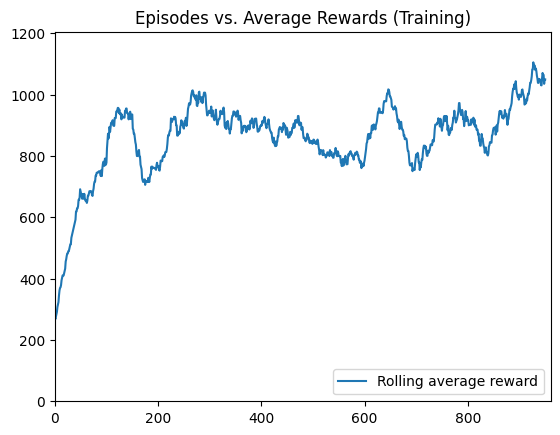

In [17]:
# Plotting the moving average of the rewards to evaluate the training
plt.title("Episodes vs. Average Rewards (Training)")
plt.plot(moving_average(total_rewards,50), label='Rolling average reward')
plt.axis([0, len(moving_average(total_rewards,40)), 0, max(moving_average(total_rewards,50))+100])
plt.legend(loc=4)
plt.show()

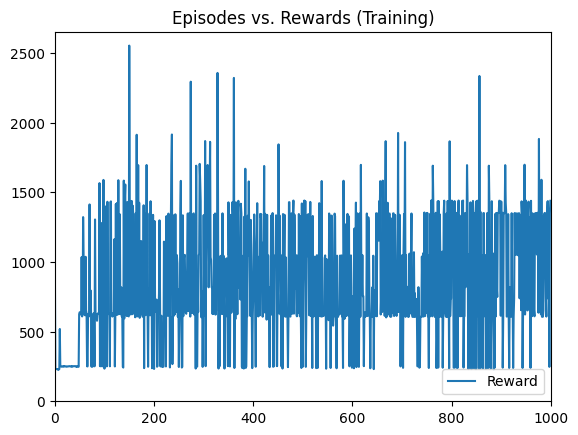

In [18]:
# Plotting the raw rewards to get an overview => not used for evaluation as it is rather confusing
plt.title("Episodes vs. Rewards (Training)")
plt.plot(total_rewards, label='Reward')
plt.axis([0, len(total_rewards), 0, max(total_rewards)+100])
plt.legend(loc=4)
plt.show()

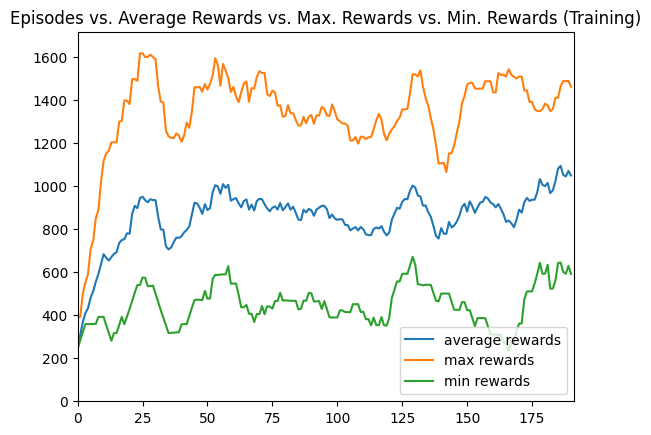

In [19]:
calculations_for_eval = calculate_intervals(total_rewards, 5)

# Plotting the min, max and average reward for intervals of size 5 to get better insights into the training performance
plt.title("Episodes vs. Average Rewards vs. Max. Rewards vs. Min. Rewards (Training)")
plt.plot(moving_average(calculations_for_eval['avg'], 10), label="average rewards")
plt.plot(moving_average(calculations_for_eval['max'], 10), label="max rewards")
plt.plot(moving_average(calculations_for_eval['min'], 10), label="min rewards")
plt.axis([0, len(moving_average(calculations_for_eval['avg'], 10)), 0, max(moving_average(calculations_for_eval['max'], 10))+100])
plt.legend(loc=4)
plt.show()